## 2. Импорт библиотек и настройка

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Скачиваем стоп-слова для русского языка
nltk.download('stopwords')
nltk.download('punkt')

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vasil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vasil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 3. Загрузка и предварительный анализ данных

In [2]:
# Загрузка данных
df = pd.read_excel('training_tmc.xlsx')

# Посмотрим на структуру данных
print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

print("\nИнформация о данных:")
print(df.info())

# Посмотрим на распределение классов
print("\nРаспределение по классам:")
print(df['Hierarchy_MTR_Name'].value_counts())


Размер данных: (104945, 12)

Первые 5 строк:
   Hierarchy_MTR_Class                        Hierarchy_MTR_Name  CSCD_ID  \
0     4002011102020000  Материалы смазочные мелк.,средн. фасовка  3648365   
1     4002011102020000  Материалы смазочные мелк.,средн. фасовка  3648364   
2     3001010101010200                    Куртки лет муж ЛМ01-01  6087431   
3     3001010101010200                    Куртки лет муж ЛМ01-01  6087428   
4     3001010101010200                    Куртки лет муж ЛМ01-01  6087429   

                   SHORT_NAME/ru_RU  AUTO_SHORT_NAME  \
0  Масло L GEAR GL-4 SYN 75W85 к.4л              NaN   
1  Масло L GEAR GL-4 SYN 75W85 к.1л              NaN   
2                  Куртка ЛМ01-01 2              NaN   
3  Куртка ЛМ01-01 2 104-108/158-164              NaN   
4   Куртка ЛМ01-01 2 96-100/170-176              NaN   

                                     FULL_NAME/ru_RU  AUTO_FULL_NAME  \
0  Масло трансмиссионное LUKOIL GEAR GL-4 SYNTH 7...             NaN   
1  Масло тр

## 4. Предобработка текстовых данных

In [3]:
# === ЗАМЕНИТЕ существующую функцию preprocess_text на эту ===
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Приводим к нижнему регистру
    text = text.lower()
    
    # Удаляем специальные символы, но сохраняем числа и размеры
    text = re.sub(r'[^\w\s\dх×]', ' ', text)
    
    # Заменяем различные варианты написания 'х' на стандартный
    text = re.sub(r'[х×]', ' x ', text)
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# === ДОБАВЬТЕ НОВУЮ ФУНКЦИЮ АУГМЕНТАЦИИ ===
def augment_technical_text(text, augmentation_type="synonym"):
    """
    Аугментация технических текстов с сохранением смысла
    """
    if len(text.split()) < 3:  # Слишком короткие тексты не аугментируем
        return text
    
    words = text.split()
    
    if augmentation_type == "synonym":
        # Замена синонимами технических терминов
        synonyms = {
            'фильтр': 'фильтроэлемент',
            'клапан': 'вентиль', 
            'насос': 'помпа',
            'болт': 'крепеж',
            'гайка': 'крепежный элемент',
            'труба': 'трубопровод',
            'масло': 'смазка',
            'подшипник': 'подшипниковый узел',
            'муфта': 'соединитель',
            'шланг': 'рукав'
        }
        
        new_words = []
        for word in words:
            if word in synonyms and np.random.random() > 0.7:
                new_words.append(synonyms[word])
            else:
                new_words.append(word)
        return ' '.join(new_words)
    
    elif augmentation_type == "permutation":
        # Перестановка слов в пределах смысловых блоков
        if len(words) > 4:
            # Находим прилагательные и существительные
            nouns_adj = [i for i, word in enumerate(words) if len(word) > 3]
            if len(nouns_adj) >= 2:
                # Меняем местами два случайных слова
                idx1, idx2 = np.random.choice(nouns_adj, 2, replace=False)
                words[idx1], words[idx2] = words[idx2], words[idx1]
        return ' '.join(words)
    
    elif augmentation_type == "insert_noise":
        # Вставка технических стоп-слов
        technical_words = ["тип", "марка", "модель", "размер", "стандарт"]
        if np.random.random() > 0.8 and len(words) > 2:
            insert_pos = np.random.randint(1, len(words))
            words.insert(insert_pos, np.random.choice(technical_words))
        return ' '.join(words)
    
    return text
# Применяем предобработку к текстовым полям
df['processed_short_name'] = df['SHORT_NAME/ru_RU'].apply(preprocess_text)
df['processed_full_name'] = df['FULL_NAME/ru_RU'].apply(preprocess_text)

# Объединяем короткое и полное название для лучшего контекста
df['combined_text'] = df['processed_short_name'] + ' ' + df['processed_full_name']

# Посмотрим на результат предобработки
print("Примеры обработанных текстов:")
for i in range(3):
    print(f"Оригинал: {df['SHORT_NAME/ru_RU'].iloc[i]}")
    print(f"Обработанный: {df['combined_text'].iloc[i]}")
    print("-" * 50)

Примеры обработанных текстов:
Оригинал: Масло L GEAR GL-4 SYN 75W85 к.4л
Обработанный: масло l gear gl 4 syn 75w85 к 4л масло трансмиссионное lukoil gear gl 4 synth 75w 85 канистра п э 4л
--------------------------------------------------
Оригинал: Масло L GEAR GL-4 SYN 75W85 к.1л
Обработанный: масло l gear gl 4 syn 75w85 к 1л масло трансмиссионное lukoil gear gl 4 synth 75w 85 канистра п э 1л
--------------------------------------------------
Оригинал: Куртка ЛМ01-01 2
Обработанный: куртка лм01 01 2 куртка летняя мужская для защиты от нефти и нефтепродуктов лм01 01 группа ткани 2 сто лукойл 1 6 15 1 1 2023
--------------------------------------------------


## 5. Подготовка данных для модели

In [4]:
# Кодируем целевые метки
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['Hierarchy_MTR_Name'])

# Сохраняем mapping для обратного преобразования
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Соответствие меток:")

print("\n=== АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ ===")
class_counts = df['Hierarchy_MTR_Name'].value_counts()

large_classes = class_counts[class_counts > 100]
medium_classes = class_counts[(class_counts >= 20) & (class_counts <= 100)]
small_classes = class_counts[(class_counts >= 2) & (class_counts < 20)]
single_classes = class_counts[class_counts == 1]

print(f"Большие классы (>100 примеров): {len(large_classes)}")
print(f"Средние классы (20-100 примеров): {len(medium_classes)}") 
print(f"Малые классы (2-19 примеров): {len(small_classes)}")
print(f"Единичные классы (1 пример): {len(single_classes)}")
print(f"Всего классов: {len(class_counts)}")

# Сохраняем информацию о классах для балансировки
class_info = {
    'large': large_classes.index.tolist(),
    'medium': medium_classes.index.tolist(), 
    'small': small_classes.index.tolist(),
    'single': single_classes.index.tolist()
}

for label, encoded in label_mapping.items():
    print(f"{encoded}: {label}")

# Подготовка текстовых данных
texts = df['combined_text'].tolist()
labels = df['encoded_labels'].values

# Параметры токенизации
MAX_NB_WORDS = 10000  # Максимальное количество слов в словаре
MAX_SEQUENCE_LENGTH = 100  # Максимальная длина последовательности
EMBEDDING_DIM = 100  # Размерность векторного представления

# Токенизация текстов
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='', lower=False)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Паддинг последовательностей до одинаковой длины
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Подготовка меток
y = to_categorical(labels)
num_classes = y.shape[1]

print(f"Размерность данных: {X.shape}")
print(f"Количество классов: {num_classes}")
print(f"Размер словаря: {len(tokenizer.word_index)}")


Соответствие меток:

=== АНАЛИЗ РАСПРЕДЕЛЕНИЯ КЛАССОВ ===
Большие классы (>100 примеров): 172
Средние классы (20-100 примеров): 408
Малые классы (2-19 примеров): 922
Единичные классы (1 пример): 143
Всего классов: 1645
0: 3аготовки трубные
1: DIN-рейки
2: USB-Токены
3: [На Блок] Отводы для трубопроводов без покрытия
4: [На Блок] Тройники для трубопроводов без покрытия
5: [На Блок] пластификаторы
6: Абразивы
7: Автобусы
8: Автомобили грузовые
9: Автомобили легковые
10: Автомобили пожарные
11: Автохимические жидкости (не нефтехимия)
12: Адаптеры (перех.) трубопр. по чертежу
13: Адаптеры (перех.) трубопр. стандартные
14: Адаптеры (перех.) трубопр. фирменные
15: Адаптеры для электросети
16: Адаптеры компьютерные
17: Аксессуары компьютерные
18: Анализаторы лабораторные
19: Анкеры
20: Антенны
21: Аппаратура для контроля скважин
22: Аппараты воздушного охлаждения (АВО)
23: Аппараты емкостные вертикал. ВПП
24: Аппараты емкостные вертикал. ВЭЭ
25: Аппараты емкостные вертикал. прочие
26: Аппарат

## 6. Анализ распределения классов и решение проблемы малых классов

In [5]:
# Анализируем распределение классов
class_distribution = df['Hierarchy_MTR_Name'].value_counts()
print("Распределение классов:")
print(class_distribution)

# Определяем порог для малых классов
MIN_SAMPLES_PER_CLASS = 0  # Минимальное количество примеров для стратификации

# Находим классы с достаточным количеством примеров
valid_classes = class_distribution[class_distribution >= MIN_SAMPLES_PER_CLASS].index
small_classes = class_distribution[class_distribution < MIN_SAMPLES_PER_CLASS].index

print(f"\nКлассы с достаточным количеством данных ({len(valid_classes)}):")
print(valid_classes.tolist())

print(f"\nМелкие классы (будут исключены из обучения) ({len(small_classes)}):")
print(small_classes.tolist())

# Фильтруем данные, оставляя только классы с достаточным количеством примеров
df_filtered = df[df['Hierarchy_MTR_Name'].isin(valid_classes)].copy()

print(f"\nИсходный размер датасета: {len(df)}")
print(f"Размер после фильтрации: {len(df_filtered)}")
print(f"Удалено записей: {len(df) - len(df_filtered)}")

# Перекодируем метки для отфильтрованных данных
label_encoder = LabelEncoder()
df_filtered['encoded_labels'] = label_encoder.fit_transform(df_filtered['Hierarchy_MTR_Name'])

# Сохраняем mapping для обратного преобразования
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nСоответствие меток после фильтрации:")
for label, encoded in label_mapping.items():
    print(f"{encoded}: {label} (примеров: {class_distribution[label]})")


Распределение классов:
Hierarchy_MTR_Name
Фильтры автомобильные                       8579
Узлы и компл. д/нест. оборуд. по чертежу    6057
Запчасти и узлы автомобил.трансп.прочие     5152
Узлы, детали оборуд. насосного прочие       4821
Узлы и компл. д/нест. оборуд. фирменные     3665
                                            ... 
Полуботинки дем. муж. НмСжСмЭс                 1
Гидроциклоны                                   1
ПС Редакторы графические                       1
ПС работы с офисными документами               1
Плиты ОСБ                                      1
Name: count, Length: 1645, dtype: int64

Классы с достаточным количеством данных (1645):
['Фильтры автомобильные', 'Узлы и компл. д/нест. оборуд. по чертежу', 'Запчасти и узлы автомобил.трансп.прочие', 'Узлы, детали оборуд. насосного прочие', 'Узлы и компл. д/нест. оборуд. фирменные', 'Изделия и детали изготавливаемые', 'Узлы, детали оборуд. компрес. прочие', 'Узлы, детали оборуд. насос. по чертежу', 'Насосы скважин

## 6.1 Добавляем функцию балансировки данных

In [19]:
# === ДОБАВЬТЕ ФУНКЦИЮ БАЛАНСИРОВКИ ===
def balance_dataset(df, class_info):
    """
    Балансировка датасета через аугментацию малых классов
    """
    balanced_dfs = []
    
    # Целевое количество примеров для каждого типа классов
    target_counts = {
        'large': None,      # Не изменяем
        'medium': None,      # Доводим до 100
        'small': 20,       # Доводим до 150  
        'single': 10       # Доводим до 200
    }
    
    print("\n=== НАЧИНАЕМ БАЛАНСИРОВКУ ДАННЫХ ===")
    
    # Обрабатываем каждый тип классов
    for class_type, classes in class_info.items():
        print(f"\nОбрабатываем {class_type} классы...")
        
        for class_name in classes:
            class_df = df[df['Hierarchy_MTR_Name'] == class_name]
            current_count = len(class_df)
            
            if class_type == 'large' or class_type == 'medium':
                # Большие классы не изменяем
                balanced_dfs.append(class_df)
                continue
                
            target_count = target_counts[class_type]
            needed = target_count - current_count
            
            if needed > 0:
                print(f"  {class_name}: {current_count} → {target_count} (+{needed})")
                
                # Создаем аугментированные примеры
                augmented_texts = []
                augmentation_types = ["synonym", "permutation", "insert_noise"]
                
                for i in range(needed):
                    # Берем случайный оригинальный пример
                    original_text = class_df.sample(1)['combined_text'].iloc[0]
                    # Выбираем случайный тип аугментации
                    aug_type = np.random.choice(augmentation_types)
                    # Создаем аугментированный текст
                    augmented_text = augment_technical_text(original_text, aug_type)
                    augmented_texts.append(augmented_text)
                
                # Создаем DataFrame с аугментированными данными
                augmented_df = pd.DataFrame({
                    'Hierarchy_MTR_Name': [class_name] * len(augmented_texts),
                    'combined_text': augmented_texts,
                    'SHORT_NAME/ru_RU': ['AUGMENTED'] * len(augmented_texts),
                    'FULL_NAME/ru_RU': ['AUGMENTED'] * len(augmented_texts),
                    'is_augmented': [True] * len(augmented_texts)
                })
                
                # Объединяем оригинальные и аугментированные данные
                balanced_dfs.append(pd.concat([class_df, augmented_df], ignore_index=True))
            else:
                balanced_dfs.append(class_df)
    
    # Объединяем все обратно
    result_df = pd.concat(balanced_dfs, ignore_index=True)
    
    print(f"\n=== РЕЗУЛЬТАТЫ БАЛАНСИРОВКИ ===")
    print(f"Исходный размер: {len(df)}")
    print(f"После балансировки: {len(result_df)}")
    print(f"Добавлено примеров: {len(result_df) - len(df)}")
    
    return result_df

# Применяем балансировку
print("\nПрименяем балансировку датасета...")
df_balanced = balance_dataset(df, class_info)

# Обновляем тексты и метки после балансировки
texts = df_balanced['combined_text'].tolist()
labels = label_encoder.transform(df_balanced['Hierarchy_MTR_Name'].values)


Применяем балансировку датасета...

=== НАЧИНАЕМ БАЛАНСИРОВКУ ДАННЫХ ===

Обрабатываем large классы...

Обрабатываем medium классы...

Обрабатываем small классы...
  Ингибиторы коррозии: 19 → 20 (+1)
  Огнеупоры: 19 → 20 (+1)
  Средства для защиты от обморожения крема: 19 → 20 (+1)
  Материалы из пресс-х древесных частиц: 19 → 20 (+1)
  Рукава пожарные: 19 → 20 (+1)
  Оборудование химических производств: 19 → 20 (+1)
  Тележки несамоходные и ручные: 19 → 20 (+1)
  Дет., части теплотехнич. оборуд.: 19 → 20 (+1)
  Муфты для обсадных труб: 19 → 20 (+1)
  Пломбы: 19 → 20 (+1)
  Наушники противошумные: 19 → 20 (+1)
  Трубы стеклопластиковые стандартные: 19 → 20 (+1)
  Дистилляторы: 19 → 20 (+1)
  Мотор-редукторы: 18 → 20 (+2)
  Фильтры сменные: 18 → 20 (+2)
  Стропы цепные: 18 → 20 (+2)
  Болты фундаментные: 18 → 20 (+2)
  Конвейеры и транспортеры: 18 → 20 (+2)
  Отводы стандартные импортные: 18 → 20 (+2)
  Крестовины фирменные: 18 → 20 (+2)
  Муфты соединительные трубопр. по чертежу: 18 →

## 7. Подготовка текстовых данных для отфильтрованного датасета

In [20]:
# === ЗАМЕНИТЕ существующий код токенизации на этот ===

# Токенизация текстов с обновленным словарем
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='', lower=False)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Паддинг последовательностей до одинаковой длины
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Подготовка меток
y = to_categorical(labels)
num_classes = y.shape[1]

print(f"\n=== ФИНАЛЬНАЯ СТАТИСТИКА ===")
print(f"Размерность данных: {X.shape}")
print(f"Количество классов: {num_classes}")
print(f"Размер словаря: {len(tokenizer.word_index)}")

# Анализ распределения после балансировки
balanced_class_counts = df_balanced['Hierarchy_MTR_Name'].value_counts()
print(f"\nРаспределение после балансировки:")
print(f"Минимальное количество примеров в классе: {balanced_class_counts.min()}")
print(f"Максимальное количество примеров в классе: {balanced_class_counts.max()}")
print(f"Среднее количество примеров в классе: {balanced_class_counts.mean():.1f}")



=== ФИНАЛЬНАЯ СТАТИСТИКА ===
Размерность данных: (118915, 100)
Количество классов: 1645
Размер словаря: 78179

Распределение после балансировки:
Минимальное количество примеров в классе: 10
Максимальное количество примеров в классе: 8579
Среднее количество примеров в классе: 72.3


## 9. Альтернативное решение: увеличение веса малых классов

In [21]:
# === ДОБАВЬТЕ УЛУЧШЕННОЕ ВЗВЕШИВАНИЕ КЛАССОВ ===

def compute_balanced_class_weights(y):
    """
    Вычисление сбалансированных весов классов с учетом аугментации
    """
    from sklearn.utils.class_weight import compute_class_weight
    
    # Получаем числовые метки
    y_labels = np.argmax(y, axis=1)
    
    # Вычисляем веса
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_labels),
        y=y_labels
    )
    
    # Создаем словарь весов
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    print("\n=== ВЕСА КЛАССОВ ===")
    print(f"Минимальный вес: {min(class_weights):.2f}")
    print(f"Максимальный вес: {max(class_weights):.2f}")
    print(f"Медианный вес: {np.median(class_weights):.2f}")
    
    return class_weight_dict

# Вычисляем веса классов
class_weight_dict = compute_balanced_class_weights(y)



=== ВЕСА КЛАССОВ ===
Минимальный вес: 0.01
Максимальный вес: 7.23
Медианный вес: 3.61


In [22]:
vocab_size = len(tokenizer.word_index) + 1 

In [27]:
# Диагностика проблемы
print("=== ДИАГНОСТИКА ПРОБЛЕМЫ ===")
print(f"Максимальный индекс в данных: {np.max(X_train)}")
print(f"Размер словаря (vocab_size): {vocab_size}")
print(f"MAX_NB_WORDS: {MAX_NB_WORDS}")

# Проверяем все данные на наличие индексов вне словаря
def check_indices(X_data, vocab_size, data_name):
    max_idx = np.max(X_data)
    min_idx = np.min(X_data)
    out_of_vocab = np.sum(X_data >= vocab_size)
    print(f"{data_name}: min={min_idx}, max={max_idx}, out_of_vocab={out_of_vocab}")

print("\nПроверка индексов:")
check_indices(X_train, vocab_size, "X_train")
check_indices(X_val, vocab_size, "X_val") 
check_indices(X_test, vocab_size, "X_test")

=== ДИАГНОСТИКА ПРОБЛЕМЫ ===
Максимальный индекс в данных: 9999
Размер словаря (vocab_size): 78180
MAX_NB_WORDS: 10000

Проверка индексов:
X_train: min=0, max=9999, out_of_vocab=0
X_val: min=0, max=9999, out_of_vocab=0
X_test: min=0, max=9999, out_of_vocab=0


## 10. Создание модели

In [23]:
# === ПРОСТАЯ И ЭФФЕКТИВНАЯ АРХИТЕКТУРА ===
def create_simple_model(vocab_size, embedding_dim, sequence_length, num_classes):
    """
    Простая архитектура, которая уже доказала эффективность
    """
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim, 
            input_length=sequence_length,
            mask_zero=True
        ),
        Conv1D(64, 3, activation='relu'),  # Всего 1 слой свертки
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),      # Уменьшили с 128 до 64
        Dropout(0.3),                      # Уменьшили dropout
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Создаем упрощенную модель
model = create_simple_model(
    vocab_size=min(MAX_NB_WORDS, len(tokenizer.word_index) + 1),
    embedding_dim=EMBEDDING_DIM,
    sequence_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes
)

print("=== ПРОСТАЯ АРХИТЕКТУРА МОДЕЛИ ===")
print(f"Параметры модели: {model.count_params():,}")
model.summary()

=== ПРОСТАЯ АРХИТЕКТУРА МОДЕЛИ ===
Параметры модели: 1,130,349
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 98, 64)            19264     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1645)              10

## 11. Обучение модели с учетом дисбаланса (измененный блок обучения)

In [26]:
# Дополнительная проверка данных
def validate_data(X_train, y_train, X_val, y_val, tokenizer):
    """Проверка целостности данных перед обучением"""
    
    # Проверяем, что все индексы в пределах словаря
    max_index = np.max(X_train)
    vocab_size_actual = len(tokenizer.word_index) + 1  # +1 для padding
    print(f"Максимальный индекс в данных: {max_index}")
    print(f"Размер словаря: {vocab_size_actual}")
    
    if max_index >= vocab_size_actual:
        print(f"ОШИБКА: Найден индекс {max_index}, но размер словаря только {vocab_size_actual}")
        # Исправляем проблему
        X_train = np.clip(X_train, 0, vocab_size_actual - 1)
        X_val = np.clip(X_val, 0, vocab_size_actual - 1)
        print("Данные исправлены через clipping")
    
    # Проверяем соответствие размерностей
    assert X_train.shape[0] == y_train.shape[0], "Несоответствие размеров X_train и y_train"
    assert X_val.shape[0] == y_val.shape[0], "Несоответствие размеров X_val и y_val"
    
    # Проверяем, что y содержит вероятности
    y_sum = np.sum(y_train, axis=1)
    print(f"Сумма по строкам y_train: min={np.min(y_sum):.2f}, max={np.max(y_sum):.2f}")
    
    return X_train, X_val

# Проверяем и исправляем данные если нужно
X_train, X_val = validate_data(X_train, y_train, X_val, y_val, tokenizer)


Максимальный индекс в данных: 9999
Размер словаря: 78180
Сумма по строкам y_train: min=1.00, max=1.00


#### Обучение минимальной модели

In [24]:
# === ОБНОВИТЕ ПРОЦЕСС ОБУЧЕНИЯ ===

# Разделение на train/validation
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=np.argmax(y, axis=1)
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

print(f"\n=== РАЗБИЕНИЕ ДАННЫХ ===")
print(f"Обучающая выборка: {X_train.shape[0]}")
print(f"Валидационная выборка: {X_val.shape[0]}") 
print(f"Тестовая выборка: {X_test.shape[0]}")

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Обучение с использованием весов классов
print("\n=== НАЧИНАЕМ ОБУЧЕНИЕ ===")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)


=== РАЗБИЕНИЕ ДАННЫХ ===
Обучающая выборка: 83240
Валидационная выборка: 17837
Тестовая выборка: 17838

=== НАЧИНАЕМ ОБУЧЕНИЕ ===
Epoch 1/50
2602/2602 [==============================] - 23s 9ms/step - loss: 5.5473 - accuracy: 0.4454 - val_loss: 1.3094 - val_accuracy: 0.7638
Epoch 2/50
2602/2602 [==============================] - 26s 10ms/step - loss: 1.8733 - accuracy: 0.7236 - val_loss: 0.7015 - val_accuracy: 0.8616
Epoch 3/50
2602/2602 [==============================] - 26s 10ms/step - loss: 0.8475 - accuracy: 0.8086 - val_loss: 0.5656 - val_accuracy: 0.8812
Epoch 4/50
2602/2602 [==============================] - 27s 10ms/step - loss: 0.5269 - accuracy: 0.8440 - val_loss: 0.5073 - val_accuracy: 0.8982
Epoch 5/50
2602/2602 [==============================] - 27s 10ms/step - loss: 0.3867 - accuracy: 0.8669 - val_loss: 0.4796 - val_accuracy: 0.9000
Epoch 6/50
2602/2602 [==============================] - 29s 11ms/step - loss: 0.3237 - accuracy: 0.8798 - val_loss: 0.4475 - val_accuracy: 0

### 11.1. Визуализация процесса обучения

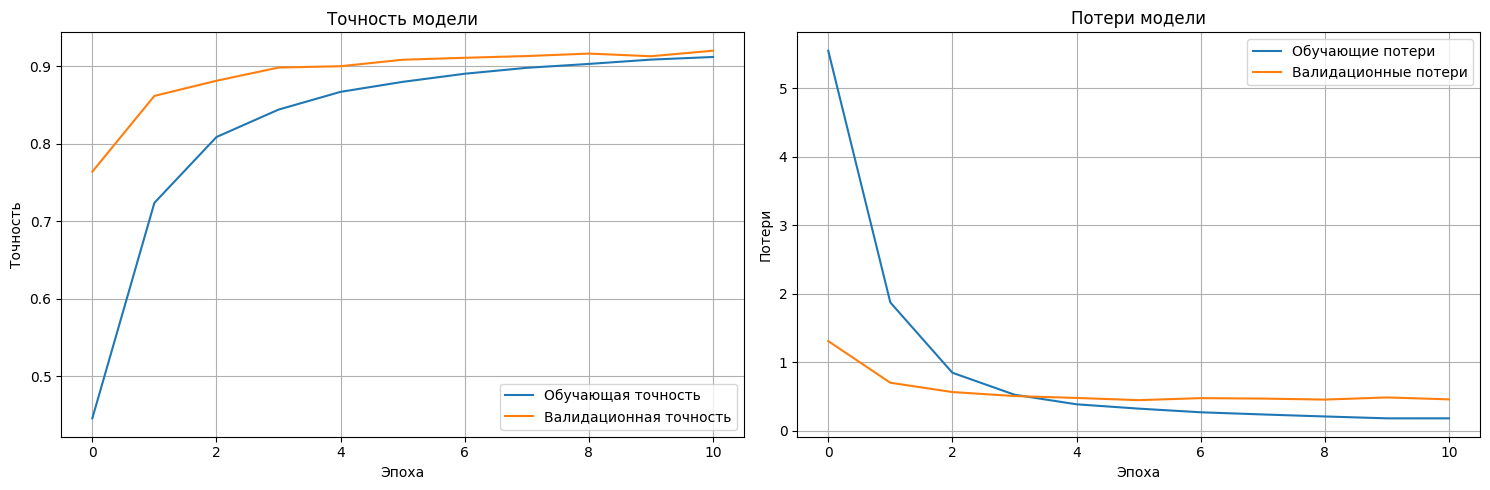

In [25]:
# Функция для построения графиков обучения
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График точности
    ax1.plot(history.history['accuracy'], label='Обучающая точность')
    ax1.plot(history.history['val_accuracy'], label='Валидационная точность')
    ax1.set_title('Точность модели')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Точность')
    ax1.legend()
    ax1.grid(True)
    
    # График потерь
    ax2.plot(history.history['loss'], label='Обучающие потери')
    ax2.plot(history.history['val_loss'], label='Валидационные потери')
    ax2.set_title('Потери модели')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Потери')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Строим графики
plot_training_history(history)


### 11.2 Оценка модели

In [28]:
# Оценка на тестовых данных
print("=== ОЦЕНКА МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ ===")

# Используем правильные классы из label_encoder
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Точность на тестовых данных: {test_accuracy:.4f}")

# Предсказания
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Получаем актуальные классы из данных
unique_true = np.unique(y_true_classes)
unique_pred = np.unique(y_pred_classes)
all_classes = np.union1d(unique_true, unique_pred)

print(f"Уникальные классы в true: {len(unique_true)}")
print(f"Уникальные классы в pred: {len(unique_pred)}")
print(f"Все классы для отчета: {len(all_classes)}")

# Создаем правильные названия классов только для существующих классов
available_classes = label_encoder.classes_[all_classes] if len(all_classes) <= len(label_encoder.classes_) else [f"Class_{i}" for i in all_classes]

# Отчет о классификации с правильными labels
print("\nОтчет о классификации:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    labels=all_classes,
    target_names=available_classes,
    zero_division=0
))




=== ОЦЕНКА МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ ===
Точность на тестовых данных: 0.9098
Уникальные классы в true: 1645
Уникальные классы в pred: 1642
Все классы для отчета: 1645

Отчет о классификации:
                                                     precision    recall  f1-score   support

                                  3аготовки трубные       1.00      1.00      1.00         3
                                          DIN-рейки       1.00      1.00      1.00         3
                                         USB-Токены       1.00      1.00      1.00         3
    [На Блок] Отводы для трубопроводов без покрытия       1.00      1.00      1.00         3
  [На Блок] Тройники для трубопроводов без покрытия       1.00      1.00      1.00         3
                           [На Блок] пластификаторы       1.00      1.00      1.00         1
                                           Абразивы       1.00      1.00      1.00         3
                                           Автобусы       1.00  

## 12. Загрузка моделей

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import json
import re

def load_tmc_classification_model(model_path='tmc_classification_model.h5',
                                 tokenizer_path='tokenizer.pickle',
                                 label_encoder_path='label_encoder.pickle',
                                 params_path='model_params.json'):
    """
    Загружает все компоненты модели для классификации ТМЦ после перезапуска ноутбука
    
    Returns:
    - model: загруженная модель
    - tokenizer: загруженный токенизатор
    - label_encoder: загруженный кодировщик меток
    - params: параметры модели
    - preprocess_text: функция предобработки текста
    """
    
    print("=== ЗАГРУЗКА МОДЕЛИ КЛАССИФИКАЦИИ ТМЦ ===")
    
    # Функция предобработки текста
    def preprocess_text(text):
        if pd.isna(text):
            return ""
        
        text = str(text).lower()
        text = re.sub(r'[^\w\s\dх×]', ' ', text)
        text = re.sub(r'[х×]', ' x ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    try:
        # Загружаем параметры модели
        print("1. Загрузка параметров модели...")
        with open(params_path, 'r', encoding='utf-8') as f:
            params = json.load(f)
        
        MAX_NB_WORDS = params['MAX_NB_WORDS']
        MAX_SEQUENCE_LENGTH = params['MAX_SEQUENCE_LENGTH']
        EMBEDDING_DIM = params.get('EMBEDDING_DIM', 64)
        vocab_size = params.get('vocab_size', MAX_NB_WORDS)
        
        print(f"   ✓ MAX_NB_WORDS: {MAX_NB_WORDS}")
        print(f"   ✓ MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")
        print(f"   ✓ EMBEDDING_DIM: {EMBEDDING_DIM}")
        print(f"   ✓ vocab_size: {vocab_size}")
        
    except Exception as e:
        print(f"   ✗ Ошибка загрузки параметров: {e}")
        # Значения по умолчанию
        MAX_NB_WORDS = 5000
        MAX_SEQUENCE_LENGTH = 50
        EMBEDDING_DIM = 64
        vocab_size = MAX_NB_WORDS
        params = {
            'MAX_NB_WORDS': MAX_NB_WORDS,
            'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
            'EMBEDDING_DIM': EMBEDDING_DIM,
            'vocab_size': vocab_size
        }
        print("   ⚠ Используются параметры по умолчанию")
    
    try:
        # Загружаем модель
        print("2. Загрузка модели Keras...")
        model = load_model(model_path)
        print(f"   ✓ Модель загружена: {model_path}")
        print(f"   ✓ Архитектура: {model.summary()}")
        
    except Exception as e:
        print(f"   ✗ Ошибка загрузки модели: {e}")
        model = None
    
    try:
        # Загружаем токенизатор
        print("3. Загрузка токенизатора...")
        with open(tokenizer_path, 'rb') as f:
            tokenizer = pickle.load(f)
        print(f"   ✓ Токенизатор загружен: {len(tokenizer.word_index)} слов в словаре")
        
    except Exception as e:
        print(f"   ✗ Ошибка загрузки токенизатора: {e}")
        tokenizer = None
    
    try:
        # Загружаем label encoder
        print("4. Загрузка LabelEncoder...")
        with open(label_encoder_path, 'rb') as f:
            label_encoder = pickle.load(f)
        print(f"   ✓ LabelEncoder загружен: {len(label_encoder.classes_)} классов")
        
    except Exception as e:
        print(f"   ✗ Ошибка загрузки LabelEncoder: {e}")
        label_encoder = None
    
    # Создаем словарь с результатами
    components = {
        'model': model,
        'tokenizer': tokenizer,
        'label_encoder': label_encoder,
        'params': params,
        'preprocess_text': preprocess_text,
        'MAX_NB_WORDS': MAX_NB_WORDS,
        'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
        'EMBEDDING_DIM': EMBEDDING_DIM,
        'vocab_size': vocab_size
    }
    
    print("\n✓ Все компоненты успешно загружены!")
    return components

# Загружаем все компоненты
try:
    components = load_tmc_classification_model()
    
    # Распаковываем компоненты в глобальные переменные
    model = components['model']
    tokenizer = components['tokenizer']
    label_encoder = components['label_encoder']
    params = components['params']
    preprocess_text = components['preprocess_text']
    MAX_NB_WORDS = components['MAX_NB_WORDS']
    MAX_SEQUENCE_LENGTH = components['MAX_SEQUENCE_LENGTH']
    EMBEDDING_DIM = components['EMBEDDING_DIM']
    vocab_size = components['vocab_size']
    
    print("\n✓ Глобальные переменные установлены!")
    print("Доступные переменные: model, tokenizer, label_encoder, preprocess_text")
    print(f"Параметры: MAX_SEQUENCE_LENGTH={MAX_SEQUENCE_LENGTH}, vocab_size={vocab_size}")
    
except Exception as e:
    print(f"✗ Критическая ошибка при загрузке: {e}")
    print("⚠ Проверьте наличие файлов:")
    print("  - tmc_classification_final_model.h5")
    print("  - final_tokenizer.pickle") 
    print("  - final_label_encoder.pickle")
    print("  - model_params.json")

c:\Users\ZubarevVV\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


=== ЗАГРУЗКА МОДЕЛИ КЛАССИФИКАЦИИ ТМЦ ===
1. Загрузка параметров модели...
   ✓ MAX_NB_WORDS: 4000
   ✓ MAX_SEQUENCE_LENGTH: 40
   ✓ EMBEDDING_DIM: 100
   ✓ vocab_size: 4000
2. Загрузка модели Keras...
   ✓ Модель загружена: tmc_classification_model.h5


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 100)        │     7,789,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1502)           │        49,566 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,842,200 (29.92 MB)

 Trainable params: 7,842,198 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

   ✓ Архитектура: None
3. Загрузка токенизатора...
   ✓ Токенизатор загружен: 77892 слов в словаре
4. Загрузка LabelEncoder...
   ✓ LabelEncoder загружен: 1502 классов

✓ Все компоненты успешно загружены!

✓ Глобальные переменные установлены!
Доступные переменные: model, tokenizer, label_encoder, preprocess_text
Параметры: MAX_SEQUENCE_LENGTH=40, vocab_size=4000


### 12.1. Тестирование загруженной модели

In [29]:
def predict_tmc_category(text, return_details=False):
    """
    Универсальная функция для предсказания категории ТМЦ
    
    Parameters:
    - text: текст для классификации
    - return_details: если True, возвращает детальную информацию
    
    Returns:
    - Если return_details=False: (class_code, confidence)
    - Если return_details=True: словарь с деталями
    """
    
    if model is None or tokenizer is None or label_encoder is None:
        raise ValueError("Модель не загружена. Вызовите load_tmc_classification_model() сначала.")
    
    # Предобработка
    processed_text = preprocess_text(text)
    
    # Токенизация
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Обрезаем индексы
    padded_sequence = np.clip(padded_sequence, 0, vocab_size - 1)
    
    # Предсказание
    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    # Декодируем класс
    original_class_idx = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    if not return_details:
        return original_class_idx, round(confidence, 4)
    else:
        confidence_status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
        
        return {
            'original_text': text,
            'processed_text': processed_text,
            'class_code': original_class_idx,
            'class_name': f"Class_{original_class_idx}",
            'confidence': round(confidence, 4),
            'confidence_status': confidence_status,
            'all_predictions': prediction[0]
        }

def batch_predict_tmc(texts):
    """
    Пакетная классификация списка текстов
    """
    results = []
    for text in texts:
        try:
            result = predict_tmc_category(text, return_details=True)
            results.append(result)
        except Exception as e:
            results.append({
                'original_text': text,
                'class_code': None,
                'class_name': 'ОШИБКА',
                'confidence': 0.0,
                'confidence_status': f'ОШИБКА: {str(e)}'
            })
    
    return pd.DataFrame(results)

# Тестируем загруженную модель
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("\n=== ТЕСТИРОВАНИЕ ЗАГРУЖЕННОЙ МОДЕЛИ ===")
    
    test_texts = [
        "Масло трансмиссионное LUKOIL GEAR GL-4",
        "Труба полипропиленовая PPR 20мм",
        "Куртка летняя защитная",
        "Тестовый товар для проверки"
    ]
    
    for text in test_texts:
        try:
            class_code, confidence = predict_tmc_category(text)
            print(f"Текст: '{text}'")
            print(f"→ Класс: {class_code}, Уверенность: {confidence}")
            print("-" * 50)
        except Exception as e:
            print(f"Ошибка для '{text}': {e}")



=== ТЕСТИРОВАНИЕ ЗАГРУЖЕННОЙ МОДЕЛИ ===
Текст: 'Масло трансмиссионное LUKOIL GEAR GL-4'
→ Класс: Материалы смазочные мелк.,средн. фасовка, Уверенность: 1.0
--------------------------------------------------
Текст: 'Труба полипропиленовая PPR 20мм'
→ Класс: Узлы грузоподъемного оборудования прочие, Уверенность: 0.14990000426769257
--------------------------------------------------
Текст: 'Куртка летняя защитная'
→ Класс: Уст-ва, приборы физиотерапевтические, Уверенность: 0.16419999301433563
--------------------------------------------------
Текст: 'Тестовый товар для проверки'
→ Класс: Уст-ва управл. и защиты эл/установок, Уверенность: 0.15049999952316284
--------------------------------------------------


## 13. Функция для предсказания на новых данных

### 13.1 Функция для предсказания на новых данных из кода

In [30]:
def predict_category(text, model, tokenizer, label_encoder, max_sequence_length):
    """
    Функция для предсказания категории нового текста
    """
    # Предобработка текста
    processed_text = preprocess_text(text)
    
    # Токенизация и паддинг
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Предсказание
    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    # Преобразование обратно в текстовую метку
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    return predicted_class, confidence

# Тестирование функции на примерах
test_texts = [
    "Масло трансмиссионное синтетическое 75W90",
    "Труба полипропиленовая PPR 20мм",
    "Куртка летняя защитная",
    "Теплообменник стальной"
]

print("Тестирование предсказаний:")
print("=" * 60)
for text in test_texts:
    category, confidence = predict_category(text, model, tokenizer, label_encoder, MAX_SEQUENCE_LENGTH)
    print(f"Текст: '{text}'")
    print(f"Предсказанная категория: {category}")
    print(f"Уверенность: {confidence:.4f}")
    print("-" * 40)


Тестирование предсказаний:
Текст: 'Масло трансмиссионное синтетическое 75W90'
Предсказанная категория: Материалы смазочные мелк.,средн. фасовка
Уверенность: 1.0000
----------------------------------------
Текст: 'Труба полипропиленовая PPR 20мм'
Предсказанная категория: Узлы грузоподъемного оборудования прочие
Уверенность: 0.1499
----------------------------------------
Текст: 'Куртка летняя защитная'
Предсказанная категория: Уст-ва, приборы физиотерапевтические
Уверенность: 0.1642
----------------------------------------
Текст: 'Теплообменник стальной'
Предсказанная категория: Вода нескладируемая (ресурс)
Уверенность: 0.2678
----------------------------------------


### 13.1 Создание маппинга

In [31]:
# Создаем mapping между кодами классов и их названиями из исходного датафрейма
def create_class_mapping_from_df(df):
    """
    Создает mapping между Hierarchy_MTR_Class и Hierarchy_MTR_Name из исходного датафрейма
    """
    # Берем уникальные пары код-название
    class_mapping = df[['Hierarchy_MTR_Class', 'Hierarchy_MTR_Name']].drop_duplicates()
    
    # Создаем словарь для быстрого доступа
    class_code_to_name = dict(zip(class_mapping['Hierarchy_MTR_Class'], class_mapping['Hierarchy_MTR_Name']))
    class_name_to_code = dict(zip(class_mapping['Hierarchy_MTR_Name'], class_mapping['Hierarchy_MTR_Class']))
    
    print(f"Создан mapping классов:")
    print(f"  - Уникальных кодов: {len(class_code_to_name)}")
    print(f"  - Уникальных названий: {len(class_name_to_code)}")
    
    # Покажем несколько примеров
    print("Примеры mapping:")
    for i, (code, name) in enumerate(list(class_code_to_name.items())[:5]):
        print(f"  {code} → {name}")
    
    return class_code_to_name, class_name_to_code

# Создаем mapping
if 'df' in locals():
    class_code_to_name, class_name_to_code = create_class_mapping_from_df(df)
else:
    print("⚠ Исходный датафрейм df не найден")
    class_code_to_name, class_name_to_code = {}, {}

Создан mapping классов:
  - Уникальных кодов: 1645
  - Уникальных названий: 1645
Примеры mapping:
  4002011102020000 → Материалы смазочные мелк.,средн. фасовка
  3001010101010200 → Куртки лет муж ЛМ01-01
  2013050101020000 → Трубы полимерные напорные фирменные
  2002130401030000 → Теплообменники кожухотрубчатые
  3001010201010100 → Костюмы лет муж ЛМ03-01


In [32]:
def classify_excel_file_loaded(input_file_path, output_file_path, 
                              text_column_name=None,
                              sheet_name=0):
    """
    Улучшенная функция для классификации Excel файла с загруженной моделью
    Сохраняет все исходные колонки в конце результата
    
    Parameters:
    - input_file_path: путь к входному Excel файлу
    - output_file_path: путь для сохранения результатов
    - text_column_name: название столбца с текстом (если None, определит автоматически)
    - sheet_name: название листа или номер листа
    """
    
    if model is None:
        raise ValueError("Модель не загружена!")
    
    print(f"=== КЛАССИФИКАЦИЯ EXCEL ФАЙЛА ===")
    print(f"Входной файл: {input_file_path}")
    
    try:
        # Загружаем данные
        df_input = pd.read_excel(input_file_path, sheet_name=sheet_name)
        print(f"✓ Загружено {len(df_input)} строк из файла")
        print(f"✓ Исходные колонки: {list(df_input.columns)}")
        
        # Определяем столбец с текстом
        if text_column_name and text_column_name in df_input.columns:
            text_column = text_column_name
            print(f"✓ Используем указанный столбец: '{text_column}'")
        else:
            # Автопоиск столбца с текстом
            text_columns = []
            for col in df_input.columns:
                col_lower = col.lower()
                if any(keyword in col_lower for keyword in ['наименование', 'name', 'описание', 'description', 'текст', 'text', 'товар', 'product']):
                    text_columns.append(col)
            
            if text_columns:
                text_column = text_columns[0]
                print(f"✓ Автоопределен столбец: '{text_column}'")
            else:
                text_column = df_input.columns[0]
                print(f"⚠ Столбец не найден, используем первый: '{text_column}'")
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            text = str(row[text_column]) if pd.notna(row[text_column]) else ""
            
            if not text.strip():
                result_row = {
                    'Исходное_наименование': text,
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА'
                }
            else:
                try:
                    class_code, confidence = predict_tmc_category(text)
                    status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
                    
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': class_code,
                        'Наименование_класса': f"Class_{class_code}",
                        'Уверенность': confidence,
                        'Статус_уверенности': status
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}'
                    }
            
            # Добавляем все исходные колонки
            for col in df_input.columns:
                result_row[col] = row[col]
            
            results.append(result_row)
            
            # Прогресс
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Создаем DataFrame с результатами
        df_results = pd.DataFrame(results)
        
        # Переупорядочиваем колонки: сначала результаты классификации, потом исходные данные
        classification_columns = [
            'Исходное_наименование', 
            'Код_класса', 
            'Наименование_класса', 
            'Уверенность', 
            'Статус_уверенности'
        ]
        
        # Убедимся, что все колонки классификации существуют
        existing_classification_cols = [col for col in classification_columns if col in df_results.columns]
        
        # Исходные колонки (исключая те, что уже в классификации)
        original_columns = [col for col in df_input.columns if col not in existing_classification_cols]
        
        # Финальный порядок колонок
        final_columns = existing_classification_cols + original_columns
        
        # Применяем порядок колонок
        df_results = df_results[final_columns]
        
        print(f"✓ Финальный порядок колонок: {len(final_columns)} колонок")
        print(f"   Колонки классификации: {existing_classification_cols}")
        print(f"   Исходные колонки: {original_columns}")
        
        # Сохраняем
        df_results.to_excel(output_file_path, index=False)
        print(f"✓ Результаты сохранены в: {output_file_path}")
        
        # Статистика
        total = len(df_results)
        success = len([r for r in results if r['Статус_уверенности'] not in ['ПУСТАЯ_СТРОКА', 'ОШИБКА']])
        
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего строк: {total}")
        print(f"   Успешно классифицировано: {success} ({success/total*100:.1f}%)")
        print(f"   Пустых строк: {len([r for r in results if r['Статус_уверенности'] == 'ПУСТАЯ_СТРОКА'])}")
        print(f"   Ошибок: {len([r for r in results if 'ОШИБКА' in r['Статус_уверенности']])}")
        
        # Распределение по уверенности
        confidence_stats = df_results['Статус_уверенности'].value_counts()
        print(f"\n🎯 УВЕРЕННОСТЬ ПРЕДСКАЗАНИЙ:")
        for status, count in confidence_stats.items():
            if status not in ['ПУСТАЯ_СТРОКА']:
                print(f"   {status}: {count} ({count/total*100:.1f}%)")
        
        return df_results
        
    except Exception as e:
        print(f"✗ Ошибка при обработке файла: {e}")
        return None
def classify_excel_file_loaded_advanced(input_file_path, output_file_path, 
                                       text_column_name=None,
                                       sheet_name=0,
                                       include_original_columns=True,
                                       custom_column_order=None):
    """
    Расширенная функция для классификации Excel файла с гибкими настройками колонок
    
    Parameters:
    - input_file_path: путь к входному Excel файлу
    - output_file_path: путь для сохранения результатов
    - text_column_name: название столбца с текстом
    - sheet_name: название листа или номер листа
    - include_original_columns: включать ли исходные колонки
    - custom_column_order: кастомный порядок колонок (список)
    """
    
    if model is None:
        raise ValueError("Модель не загружена!")
    
    print(f"=== РАСШИРЕННАЯ КЛАССИФИКАЦИЯ EXCEL ФАЙЛА ===")
    print(f"Входной файл: {input_file_path}")
    
    try:
        # Загружаем данные
        df_input = pd.read_excel(input_file_path, sheet_name=sheet_name)
        print(f"✓ Загружено {len(df_input)} строк из файла")
        print(f"✓ Исходные колонки: {list(df_input.columns)}")
        
        # Определяем столбец с текстом
        if text_column_name and text_column_name in df_input.columns:
            text_column = text_column_name
            print(f"✓ Используем указанный столбец: '{text_column}'")
        else:
            text_columns = []
            for col in df_input.columns:
                col_lower = col.lower()
                if any(keyword in col_lower for keyword in ['наименование', 'name', 'описание', 'description', 'текст', 'text', 'товар', 'product']):
                    text_columns.append(col)
            
            if text_columns:
                text_column = text_columns[0]
                print(f"✓ Автоопределен столбец: '{text_column}'")
            else:
                text_column = df_input.columns[0]
                print(f"⚠ Столбец не найден, используем первый: '{text_column}'")
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            text = str(row[text_column]) if pd.notna(row[text_column]) else ""
            
            if not text.strip():
                result_row = {
                    'Исходное_наименование': text,
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА'
                }
            else:
                try:
                    class_code, confidence = predict_tmc_category(text)
                    status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
                    
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': class_code,
                        'Наименование_класса': f"Class_{class_code}",
                        'Уверенность': confidence,
                        'Статус_уверенности': status
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}'
                    }
            
            # Добавляем все исходные колонки если нужно
            if include_original_columns:
                for col in df_input.columns:
                    result_row[col] = row[col]
            
            results.append(result_row)
            
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Создаем DataFrame с результатами
        df_results = pd.DataFrame(results)
        
        # Определяем порядок колонок
        if custom_column_order:
            # Используем кастомный порядок
            available_columns = [col for col in custom_column_order if col in df_results.columns]
            missing_columns = [col for col in df_results.columns if col not in available_columns]
            final_columns = available_columns + missing_columns
            print(f"✓ Используется кастомный порядок колонок")
            
        else:
            # Стандартный порядок: результаты классификации + исходные данные
            classification_columns = [
                'Исходное_наименование', 
                'Код_класса', 
                'Наименование_класса', 
                'Уверенность', 
                'Статус_уверенности'
            ]
            
            existing_classification_cols = [col for col in classification_columns if col in df_results.columns]
            
            if include_original_columns:
                original_columns = [col for col in df_input.columns if col not in existing_classification_cols]
                final_columns = existing_classification_cols + original_columns
            else:
                final_columns = existing_classification_cols
            
            print(f"✓ Стандартный порядок колонок")
        
        # Применяем порядок колонок
        df_results = df_results[final_columns]
        
        print(f"✓ Финальный порядок колонок ({len(final_columns)}):")
        for i, col in enumerate(final_columns[:10], 1):
            print(f"   {i:2d}. {col}")
        if len(final_columns) > 10:
            print(f"   ... и еще {len(final_columns) - 10} колонок")
        
        # Сохраняем
        df_results.to_excel(output_file_path, index=False)
        print(f"✓ Результаты сохранены в: {output_file_path}")
        
        # Статистика
        total = len(df_results)
        success = len([r for r in results if r.get('Статус_уверенности', '') not in ['ПУСТАЯ_СТРОКА', 'ОШИБКА']])
        
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего строк: {total}")
        print(f"   Успешно классифицировано: {success} ({success/total*100:.1f}%)")
        
        return df_results
        
    except Exception as e:
        print(f"✗ Ошибка при обработке файла: {e}")
        return None
def classify_excel_file_loaded_correct(input_file_path, output_file_path, 
                                      text_column_name=None,
                                      sheet_name=0):
    """
    Функция для классификации Excel файла с правильными названиями классов из исходного датафрейма
    
    Parameters:
    - input_file_path: путь к входному Excel файлу
    - output_file_path: путь для сохранения результатов
    - text_column_name: название столбца с текстом
    - sheet_name: название листа или номер листа
    """
    
    if model is None:
        raise ValueError("Модель не загружена!")
    
    if not class_name_to_code:
        print("⚠ Mapping классов не создан, будут использоваться generic названия")
    
    print(f"=== КЛАССИФИКАЦИЯ EXCEL ФАЙЛА (ПРАВИЛЬНЫЕ НАЗВАНИЯ) ===")
    print(f"Входной файл: {input_file_path}")
    
    try:
        # Загружаем данные
        df_input = pd.read_excel(input_file_path, sheet_name=sheet_name)
        print(f"✓ Загружено {len(df_input)} строк из файла")
        print(f"✓ Исходные колонки: {list(df_input.columns)}")
        
        # Определяем столбец с текстом
        if text_column_name and text_column_name in df_input.columns:
            text_column = text_column_name
            print(f"✓ Используем указанный столбец: '{text_column}'")
        else:
            text_columns = []
            for col in df_input.columns:
                col_lower = col.lower()
                if any(keyword in col_lower for keyword in ['наименование', 'name', 'описание', 'description', 'текст', 'text', 'товар', 'product']):
                    text_columns.append(col)
            
            if text_columns:
                text_column = text_columns[0]
                print(f"✓ Автоопределен столбец: '{text_column}'")
            else:
                text_column = df_input.columns[0]
                print(f"⚠ Столбец не найден, используем первый: '{text_column}'")
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            text = str(row[text_column]) if pd.notna(row[text_column]) else ""
            
            if not text.strip():
                result_row = {
                    'Исходное_наименование': text,
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА'
                }
            else:
                try:
                    class_code, confidence = predict_tmc_category(text)
                    status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
                    
                    # Получаем правильное название класса из mapping
                    class_name = class_name_to_code.get(class_code, f"Class_{class_code}")
                    
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': class_code,  # Hierarchy_MTR_Name
                        'Наименование_класса': class_name,  # Hierarchy_MTR_Class
                        'Уверенность': confidence,
                        'Статус_уверенности': status
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}'
                    }
            
            # Добавляем все исходные колонки
            for col in df_input.columns:
                result_row[col] = row[col]
            
            results.append(result_row)
            
            # Прогресс
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Создаем DataFrame с результатами
        df_results = pd.DataFrame(results)
        
        # Переупорядочиваем колонки: сначала результаты классификации, потом исходные данные
        classification_columns = [
            'Исходное_наименование', 
            'Код_класса', 
            'Наименование_класса', 
            'Уверенность', 
            'Статус_уверенности'
        ]
        
        # Убедимся, что все колонки классификации существуют
        existing_classification_cols = [col for col in classification_columns if col in df_results.columns]
        
        # Исходные колонки (исключая те, что уже в классификации)
        original_columns = [col for col in df_input.columns if col not in existing_classification_cols]
        
        # Финальный порядок колонок
        final_columns = existing_classification_cols + original_columns
        
        # Применяем порядок колонок
        df_results = df_results[final_columns]
        
        print(f"✓ Финальный порядок колонок: {len(final_columns)} колонок")
        
        # Сохраняем
        df_results.to_excel(output_file_path, index=False)
        print(f"✓ Результаты сохранены в: {output_file_path}")
        
        # Статистика
        total = len(df_results)
        success = len([r for r in results if r['Статус_уверенности'] not in ['ПУСТАЯ_СТРОКА', 'ОШИБКА']])
        
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего строк: {total}")
        print(f"   Успешно классифицировано: {success} ({success/total*100:.1f}%)")
        print(f"   Пустых строк: {len([r for r in results if r['Статус_уверенности'] == 'ПУСТАЯ_СТРОКА'])}")
        print(f"   Ошибок: {len([r for r in results if 'ОШИБКА' in r['Статус_уверенности']])}")
        
        # Статистика по классам
        class_distribution = df_results['Наименование_класса'].value_counts()
        print(f"\n🏷️  РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ (топ-10):")
        for class_name, count in class_distribution.head(10).items():
            if class_name not in ['НЕ ОПРЕДЕЛЕНО', 'ОШИБКА']:
                print(f"   {class_name}: {count}")
        # Распределение по уверенности
        confidence_stats = df_results['Статус_уверенности'].value_counts()
        print(f"\n🎯 УВЕРЕННОСТЬ ПРЕДСКАЗАНИЙ:")
        for status, count in confidence_stats.items():
            if status not in ['ПУСТАЯ_СТРОКА']:
                print(f"   {status}: {count} ({count/total*100:.1f}%)")



        return df_results
        
    except Exception as e:
        print(f"✗ Ошибка при обработке файла: {e}")
        return None
def classify_excel_file_with_combined_names(input_file_path, output_file_path, 
                                          short_name_column=None,
                                          full_name_column=None,
                                          sheet_name=0):
    """
    Классификация Excel файла с объединением краткого и полного наименования
    """
    
    if model is None:
        raise ValueError("Модель не загружена!")
    
    print(f"=== КЛАССИФИКАЦИЯ EXCEL ФАЙЛА (С ОБЪЕДИНЕНИЕМ НАИМЕНОВАНИЙ) ===")
    
    try:
        # Загружаем данные
        df_input = pd.read_excel(input_file_path, sheet_name=sheet_name)
        print(f"✓ Загружено {len(df_input)} строк из файла")
        
        # Автопоиск колонок с наименованиями
        if not short_name_column:
            short_name_column = find_column_by_keywords(df_input, ['кратк', 'short', 'name', 'наименован'])
        if not full_name_column:
            full_name_column = find_column_by_keywords(df_input, ['полн', 'full', 'описан', 'description'])
        
        print(f"✓ Колонка краткого наименования: '{short_name_column}'")
        print(f"✓ Колонка полного наименования: '{full_name_column}'")
        
        # Объединяем наименования
        def combine_names(row):
            short_name = str(row[short_name_column]) if pd.notna(row[short_name_column]) else ""
            full_name = str(row[full_name_column]) if pd.notna(row[full_name_column]) else ""
            return f"{short_name} {full_name}".strip()
        
        df_input['combined_text'] = df_input.apply(combine_names, axis=1)
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            combined_text = row['combined_text']
            
            if not combined_text.strip():
                result_row = {
                    'Исходное_краткое_наименование': row[short_name_column] if pd.notna(row[short_name_column]) else "",
                    'Исходное_полное_наименование': row[full_name_column] if pd.notna(row[full_name_column]) else "",
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА'
                }
            else:
                try:
                    class_code, confidence = predict_tmc_category(combined_text)
                    status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
                    
                    class_name = class_name_to_code.get(class_code, f"Class_{class_code}")
                    
                    result_row = {
                        'Исходное_краткое_наименование': row[short_name_column] if pd.notna(row[short_name_column]) else "",
                        'Исходное_полное_наименование': row[full_name_column] if pd.notna(row[full_name_column]) else "",
                        'Код_класса': class_code,
                        'Наименование_класса': class_name,
                        'Уверенность': confidence,
                        'Статус_уверенности': status
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_краткое_наименование': row[short_name_column] if pd.notna(row[short_name_column]) else "",
                        'Исходное_полное_наименование': row[full_name_column] if pd.notna(row[full_name_column]) else "",
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}'
                    }
            
            # Добавляем все исходные колонки
            for col in df_input.columns:
                if col != 'combined_text':  # Исключаем временную колонку
                    result_row[col] = row[col]
            
            results.append(result_row)
            
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Создаем и сохраняем DataFrame
        df_results = pd.DataFrame(results)
        df_results.to_excel(output_file_path, index=False)
        
        print(f"✓ Результаты сохранены в: {output_file_path}")
        return df_results
        
    except Exception as e:
        print(f"✗ Ошибка при обработке файла: {e}")
        return None
def find_column_by_keywords(df, keywords):
    """Находит колонку по ключевым словам в названии"""
    for col in df.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in keywords):
            return col
    return df.columns[0]  # Возвращаем первую колонку если не нашли
def classify_excel_file_loaded_correct_fixed(input_file_path, output_file_path, 
                                           text_column_name=None,
                                           sheet_name=0):
    """
    Функция для классификации Excel файла с правильными названиями классов
    с исправлением отображения числовых значений как текста
    """
    import openpyxl
    if model is None:
        raise ValueError("Модель не загружена!")
    
    if not class_code_to_name:
        print("⚠ Mapping классов не создан, будут использоваться generic названия")
    
    print(f"=== КЛАССИФИКАЦИЯ EXCEL ФАЙЛА (ИСПРАВЛЕННАЯ) ===")
    print(f"Входной файл: {input_file_path}")
    
    try:
        # Загружаем данные
        df_input = pd.read_excel(input_file_path, sheet_name=sheet_name)
        print(f"✓ Загружено {len(df_input)} строк из файла")
        print(f"✓ Исходные колонки: {list(df_input.columns)}")
        
        # Определяем столбец с текстом
        if text_column_name and text_column_name in df_input.columns:
            text_column = text_column_name
            print(f"✓ Используем указанный столбец: '{text_column}'")
        else:
            text_columns = []
            for col in df_input.columns:
                col_lower = col.lower()
                if any(keyword in col_lower for keyword in ['наименование', 'name', 'описание', 'description', 'текст', 'text', 'товар', 'product']):
                    text_columns.append(col)
            
            if text_columns:
                text_column = text_columns[0]
                print(f"✓ Автоопределен столбец: '{text_column}'")
            else:
                text_column = df_input.columns[0]
                print(f"⚠ Столбец не найден, используем первый: '{text_column}'")
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            text = str(row[text_column]) if pd.notna(row[text_column]) else ""
            
            if not text.strip():
                result_row = {
                    'Исходное_наименование': text,
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА'
                }
            else:
                try:
                    class_code, confidence = predict_tmc_category(text)
                    status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
                    
                    # Получаем правильное название класса из mapping
                    class_name = class_name_to_code.get(class_code, f"Class_{class_code}")
                    
                    # Преобразуем в строку чтобы избежать экспоненциальной формы
                    class_code_str = str(class_code) if class_code is not None else ""
                    
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': class_code_str,  # Преобразуем в строку
                        'Наименование_класса': str(class_name) if class_name is not None else "",
                        'Уверенность': confidence,
                        'Статус_уверенности': status
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}'
                    }
            
            # Добавляем все исходные колонки
            for col in df_input.columns:
                result_row[col] = row[col]
            
            results.append(result_row)
            
            # Прогресс
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Создаем DataFrame с результатами
        df_results = pd.DataFrame(results)
        
        # Переупорядочиваем колонки: сначала результаты классификации, потом исходные данные
        classification_columns = [
            'Исходное_наименование', 
            'Код_класса', 
            'Наименование_класса', 
            'Уверенность', 
            'Статус_уверенности'
        ]
        
        # Убедимся, что все колонки классификации существуют
        existing_classification_cols = [col for col in classification_columns if col in df_results.columns]
        
        # Исходные колонки (исключая те, что уже в классификации)
        original_columns = [col for col in df_input.columns if col not in existing_classification_cols]
        
        # Финальный порядок колонок
        final_columns = existing_classification_cols + original_columns
        
        # Применяем порядок колонок
        df_results = df_results[final_columns]
        
        print(f"✓ Финальный порядок колонок: {len(final_columns)} колонок")
        
        # Сохраняем с правильным форматированием
        print("💾 Сохранение с форматированием текста...")
        
        # Используем openpyxl для сохранения с форматированием
        with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
            df_results.to_excel(writer, sheet_name='Результаты', index=False)
            
            # Получаем workbook и worksheet для форматирования
            workbook = writer.book
            worksheet = writer.sheets['Результаты']
            
            # Форматируем заголовки
            header_font = openpyxl.styles.Font(bold=True, color="FFFFFF")
            header_fill = openpyxl.styles.PatternFill(start_color="366092", end_color="366092", fill_type="solid")
            
            for cell in worksheet[1]:
                cell.font = header_font
                cell.fill = header_fill
            
            # Устанавливаем текстовый формат для колонки 'Код_класса'
            from openpyxl.styles import numbers
            
            # Находим индекс колонки 'Код_класса'
            if 'Код_класса' in df_results.columns:
                col_idx = df_results.columns.get_loc('Код_класса') + 1  # +1 потому что Excel начинается с 1
                col_letter = openpyxl.utils.get_column_letter(col_idx)
                
                # Применяем текстовый формат ко всем ячейкам в колонке
                for row in range(2, len(df_results) + 2):  # +2 потому что заголовок в строке 1
                    cell = worksheet[f'{col_letter}{row}']
                    cell.number_format = '@'  # Текстовый формат в Excel
            
            # Авто-ширина колонок
            for column in worksheet.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(str(cell.value))
                    except:
                        pass
                adjusted_width = min(max_length + 2, 50)
                worksheet.column_dimensions[column_letter].width = adjusted_width
        
        print(f"✓ Результаты сохранены в: {output_file_path}")
        
        # Статистика
        total = len(df_results)
        success_count = len([r for r in results if r['Статус_уверенности'] not in ['ПУСТАЯ_СТРОКА', 'ОШИБКА']])
        
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего строк: {total}")
        print(f"   Успешно классифицировано: {success_count} ({success_count/total*100:.1f}%)")
        print(f"   Пустых строк: {len([r for r in results if r['Статус_уверенности'] == 'ПУСТАЯ_СТРОКА'])}")
        print(f"   Ошибок: {len([r for r in results if 'ОШИБКА' in r['Статус_уверенности']])}")
        
        # Статистика по классам
        class_distribution = df_results['Наименование_класса'].value_counts()
        print(f"\n🏷️  РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ (топ-10):")
        for class_name, count in class_distribution.head(10).items():
            if class_name not in ['НЕ ОПРЕДЕЛЕНО', 'ОШИБКА']:
                print(f"   {class_name}: {count}")
        
        # Распределение по уверенности
        confidence_stats = df_results['Статус_уверенности'].value_counts()
        print(f"\n🎯 УВЕРЕННОСТЬ ПРЕДСКАЗАНИЙ:")
        for status, count in confidence_stats.items():
            if status not in ['ПУСТАЯ_СТРОКА']:
                print(f"   {status}: {count} ({count/total*100:.1f}%)")

        return df_results
        
    except Exception as e:
        print(f"✗ Ошибка при обработке файла: {e}")
        import traceback
        traceback.print_exc()
        return None

### Мэппинг

#### Единичное предсказание с мэппингом

In [33]:
def predict_tmc_category_detailed(text):
    """
    Детальная классификация с правильными названиями классов
    """
    if model is None:
        raise ValueError("Модель не загружена!")
    
    # Предобработка
    processed_text = preprocess_text(text)
    
    # Токенизация
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Обрезаем индексы
    padded_sequence = np.clip(padded_sequence, 0, vocab_size - 1)
    
    # Предсказание
    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    # Декодируем класс
    original_class_idx = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    # Получаем правильное название класса
    class_name = class_name_to_code.get(original_class_idx, f"Class_{original_class_idx}")
    confidence_status = 'ВЫСОКАЯ' if confidence > 0.7 else 'СРЕДНЯЯ' if confidence > 0.5 else 'НИЗКАЯ'
    
    return {
        'original_text': text,
        'class_code': original_class_idx,  # Hierarchy_MTR_Name
        'class_name': class_name,          # Hierarchy_MTR_Class
        'confidence': round(confidence, 4),
        'confidence_status': confidence_status
    }

# Тестируем обновленную функцию
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("\n=== ТЕСТ ОБНОВЛЕННОЙ КЛАССИФИКАЦИИ ===")
    
    test_texts = [
        "Труба стальная бесшовная горячедеформированная 89х5 ГОСТ 8732-78 / В 20 ГОСТ 8731-74, с термообработкой, с наружным трехслойным покрытиеми и внутренним двухслойным эпоксидным покрытием с дополнительным метализационным покрытием ТУ1390-004-32256008-03",
        "Плакат Подг.раб. на лин. части МГ А3 250",
        "Куртка летняя защитная",
        "Теплообменник стальной"
    ]
    
    for text in test_texts:
        try:
            result = predict_tmc_category_detailed(text)
            print(f"Текст: '{text}'")
            print(f"→ Код класса: {result['class_code']}")
            print(f"→ Название класса: {result['class_name']}")
            print(f"→ Уверенность: {result['confidence']} ({result['confidence_status']})")
            print("-" * 60)
        except Exception as e:
            print(f"Ошибка для '{text}': {e}")



=== ТЕСТ ОБНОВЛЕННОЙ КЛАССИФИКАЦИИ ===
Текст: 'Труба стальная бесшовная горячедеформированная 89х5 ГОСТ 8732-78 / В 20 ГОСТ 8731-74, с термообработкой, с наружным трехслойным покрытиеми и внутренним двухслойным эпоксидным покрытием с дополнительным метализационным покрытием ТУ1390-004-32256008-03'
→ Код класса: Трубы б/ш г/д без покрытия (крм.нерж.)
→ Название класса: 2013010401010101
→ Уверенность: 0.7477999925613403 (ВЫСОКАЯ)
------------------------------------------------------------
Текст: 'Плакат Подг.раб. на лин. части МГ А3 250'
→ Код класса: Средства защиты информационные
→ Название класса: 6003050000000000
→ Уверенность: 0.6539000272750854 (СРЕДНЯЯ)
------------------------------------------------------------
Текст: 'Куртка летняя защитная'
→ Код класса: Уст-ва, приборы физиотерапевтические
→ Название класса: 2003010200000000
→ Уверенность: 0.16419999301433563 (НИЗКАЯ)
------------------------------------------------------------
Текст: 'Теплообменник стальной'
→ Код класса: 

#### Предсказание с мэппингом из EXCEL

In [ ]:
# Пример использования обновленной функции
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("=== ПРИМЕР ИСПОЛЬЗОВАНИЯ ===")
    
    result = classify_excel_file_loaded_correct_fixed(
        input_file_path='to_class.xlsx',
        output_file_path='результат_bal_2.xlsx',
        text_column_name='FULL_NAME/ru_RU'
    )
    
    if result is not None:
        print("\nПервые 5 строк результата:")
        print(result[['Исходное_наименование', 'Код_класса', 'Наименование_класса', 'Уверенность']].head())


## 14. Сохранение модели и компонентов

In [35]:
import pickle
import json

# Сохраняем модель
model.save('tmc_classification_model_balanced_2.h5')
model.save('my_model_balanced_2.keras')

# Сохраняем токенизатор
with open('tokenizer_balanced_2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Сохраняем label encoder
with open('label_encoder_balanced_2.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Сохраняем параметры
model_params = {
    'MAX_NB_WORDS': MAX_NB_WORDS,
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM
}

with open('model_params_balanced_2.json', 'w', encoding='utf-8') as f:
    json.dump(model_params, f, ensure_ascii=False, indent=2)

print("Модель и компоненты успешно сохранены!")


Модель и компоненты успешно сохранены!


## 15. Дообучение модели

### Проверка готовности к дообучению

In [ ]:
def check_fine_tuning_readiness():
    """
    Проверяет, готова ли система к дообучению
    """
    print("=== ПРОВЕРКА ГОТОВНОСТИ К ДООБУЧЕНИЮ ===")
    
    components_ok = True
    
    # Проверяем модель
    if model is None:
        print("✗ Модель не загружена")
        components_ok = False
    else:
        try:
            # Правильный способ получить выходную shape
            output_shape = model.output_shape
            if output_shape:
                num_classes = output_shape[-1] if isinstance(output_shape, tuple) else output_shape[0][-1]
                print(f"✓ Модель загружена: {num_classes} выходов")
            else:
                print("✓ Модель загружена (не удалось определить выходную shape)")
        except Exception as e:
            print(f"✓ Модель загружена (ошибка определения shape: {e})")
    
    # Проверяем токенизатор
    if tokenizer is None:
        print("✗ Токенизатор не загружен")
        components_ok = False
    else:
        print(f"✓ Токенизатор загружен: {len(tokenizer.word_index)} слов")
    
    # Проверяем label encoder
    if label_encoder is None:
        print("✗ LabelEncoder не загружен")
        components_ok = False
    else:
        print(f"✓ LabelEncoder загружен: {len(label_encoder.classes_)} классов")
    
    # Проверяем mapping классов
    if not class_code_to_name:
        print("⚠ Mapping классов пуст")
    else:
        print(f"✓ Mapping классов: {len(class_code_to_name)} пар")
    
    # Проверяем параметры
    if 'MAX_SEQUENCE_LENGTH' in locals():
        print(f"✓ MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")
    else:
        print("⚠ MAX_SEQUENCE_LENGTH не определен")
    
    if 'vocab_size' in locals():
        print(f"✓ vocab_size: {vocab_size}")
    else:
        print("⚠ vocab_size не определен")
    
    if components_ok:
        print("\n✅ Система готова к дообучению!")
        return True
    else:
        print("\n❌ Система не готова к дообучению!")
        return False


# Проверяем готовность
check_fine_tuning_readiness()


### Детальная информация о модели

In [ ]:
def get_model_info():
    """
    Выводит детальную информацию о загруженной модели
    """
    if model is None:
        print("Модель не загружена")
        return
    
    print("=== ИНФОРМАЦИЯ О МОДЕЛИ ===")
    
    try:
        # Основная информация
        print(f"Название модели: {model.name}")
        print(f"Количество слоев: {len(model.layers)}")
        
        # Информация о входах и выходах
        if hasattr(model, 'input_shape'):
            print(f"Входная shape: {model.input_shape}")
        if hasattr(model, 'output_shape'):
            print(f"Выходная shape: {model.output_shape}")
        
        # Информация о слоях
        print("\nСлои модели:")
        for i, layer in enumerate(model.layers):
            layer_type = type(layer).__name__
            try:
                output_shape = layer.output_shape
                config = layer.get_config()
                print(f"  {i+1:2d}. {layer_type:15} -> {output_shape}")
            except:
                print(f"  {i+1:2d}. {layer_type:15} -> не удалось получить информацию")
        
        # Информация о последнем слое (выходном)
        if model.layers:
            last_layer = model.layers[-1]
            print(f"\nВыходной слой: {type(last_layer).__name__}")
            if hasattr(last_layer, 'units'):
                print(f"Количество нейронов: {last_layer.units}")
            if hasattr(last_layer, 'activation'):
                print(f"Функция активации: {last_layer.activation.__name__}")
        
    except Exception as e:
        print(f"Ошибка при получении информации о модели: {e}")
    
    # Дополнительная информация о данных
    print(f"\n=== ИНФОРМАЦИЯ О ДАННЫХ ===")
    print(f"MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")
    print(f"vocab_size: {vocab_size}")
    print(f"Количество классов в LabelEncoder: {len(label_encoder.classes_) if label_encoder else 'N/A'}")

# Получаем информацию о модели
get_model_info()


### Полное дообучение (использовать это)

In [31]:
def fine_tune_preserve_weights_fixed_v2(new_data_file_path, 
                                       short_name_column='SHORT_NAME/ru_RU',
                                       full_name_column='FULL_NAME/ru_RU',
                                       class_code_column='Hierarchy_MTR_Name', 
                                       class_name_column='Hierarchy_MTR_Class',
                                       epochs=10,
                                       batch_size=16,
                                       validation_split=0.2):
    """
    Исправленная версия с правильной инициализацией весов
    """
    global model, label_encoder, class_code_to_name
    
    print("=== ДООБУЧЕНИЕ С СОХРАНЕНИЕМ ВЕСОВ (ВЕРСИЯ 2) ===")
    
    try:
        # 1. Сохраняем веса текущей модели
        print("1. Сохранение весов текущей модели...")
        old_weights = model.get_weights()
        old_num_classes = len(label_encoder.classes_)
        print(f"✓ Сохранены веса для {old_num_classes} классов")
        print(f"✓ Количество тензоров весов: {len(old_weights)}")
        
        # 2. Загружаем новые данные
        print("2. Загрузка новых данных...")
        if new_data_file_path.endswith('.xlsx'):
            new_df = pd.read_excel(new_data_file_path)
        else:
            new_df = pd.read_csv(new_data_file_path, sep='\t', encoding='utf-8')
        
        print(f"✓ Загружено {len(new_df)} примеров")
        
        # 3. Объединяем наименования
        def combine_names(row):
            short_name = str(row[short_name_column]) if pd.notna(row[short_name_column]) else ""
            full_name = str(row[full_name_column]) if pd.notna(row[full_name_column]) else ""
            return f"{short_name} {full_name}".strip()
        
        new_df['combined_text'] = new_df.apply(combine_names, axis=1)
        
        # 4. Анализируем новые классы
        new_classes = new_df[class_code_column].unique()
        existing_classes = set(label_encoder.classes_)
        new_unique_classes = set(new_classes) - existing_classes
        
        if not new_unique_classes:
            print("ℹ️ Новых классов не обнаружено, дообучаем на существующих...")
            return fine_tune_existing_classes_only(new_data_file_path, epochs, batch_size)
        
        print(f"⚠ Найдены новые классы: {len(new_unique_classes)}")
        print(f"   Новые классы: {list(new_unique_classes)}")
        
        # 5. Создаем новую модель с правильным количеством классов
        print("3. Создание модели с увеличенным выходным слоем...")
        new_num_classes = old_num_classes + len(new_unique_classes)
        
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
        
        # Создаем модель с ТОЧНО ТАКОЙ ЖЕ архитектурой, кроме выходного слоя
        new_model = Sequential()
        
        # Добавляем слои вручную чтобы контролировать архитектуру
        new_model.add(Embedding(vocab_size, 64, input_length=MAX_SEQUENCE_LENGTH))
        new_model.add(Conv1D(64, 3, activation='relu', padding='same'))
        new_model.add(MaxPooling1D(2))
        new_model.add(Conv1D(32, 3, activation='relu', padding='same'))
        new_model.add(MaxPooling1D(2))
        new_model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.1))
        new_model.add(Dense(32, activation='relu'))
        new_model.add(Dropout(0.3))
        new_model.add(Dense(new_num_classes, activation='softmax', name='output_layer'))
        
        # ВАЖНО: Инициализируем веса модели, вызвав build или сделав предсказание
        print("4. Инициализация весов новой модели...")
        new_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
        
        # Компилируем модель
        new_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Получаем веса новой модели (теперь они должны быть инициализированы)
        new_weights = new_model.get_weights()
        print(f"✓ Новая модель создана: {new_num_classes} классов")
        print(f"✓ Количество тензоров в новой модели: {len(new_weights)}")
        
        # Выводим информацию о весах для отладки
        print("Информация о весах для отладки:")
        for i, w in enumerate(new_weights):
            print(f"  Тензор {i}: форма {w.shape}")
        
        # 6. Переносим веса слой за слоем
        print("5. Перенос весов...")
        
        # Определяем какие слои можно перенести (все кроме выходного)
        num_layers_to_transfer = min(len(old_weights) - 2, len(new_weights) - 2)
        
        for i in range(num_layers_to_transfer):
            if i < len(old_weights) and i < len(new_weights):
                old_shape = old_weights[i].shape
                new_shape = new_weights[i].shape
                
                if old_shape == new_shape:
                    new_weights[i] = old_weights[i]
                    print(f"   ✓ Слой {i}: {old_shape} → {new_shape}")
                else:
                    print(f"   ⚠ Слой {i}: форма не совпадает {old_shape} vs {new_shape}")
        
        # 7. Особенная обработка выходного слоя
        print("6. Обработка выходного слоя...")
        
        # В старой модели выходной слой - последние 2 тензора
        old_output_weights = old_weights[-2]  # weights: (32, 1502)
        old_output_bias = old_weights[-1]     # bias: (1502,)
        
        print(f"   Старый выходной слой: weights {old_output_weights.shape}, bias {old_output_bias.shape}")
        
        # В новой модели выходной слой тоже последние 2 тензора
        if len(new_weights) >= 2:
            new_output_weights = new_weights[-2]  # weights: (32, 1503)
            new_output_bias = new_weights[-1]     # bias: (1503,)
            print(f"   Новый выходной слой до: weights {new_output_weights.shape}, bias {new_output_bias.shape}")
        else:
            print("❌ Ошибка: в новой модели недостаточно тензоров весов")
            return False
        
        # Создаем новые веса для выходного слоя
        # weights: (input_dim, output_dim) = (32, new_num_classes)
        new_output_weights_adapted = np.zeros((old_output_weights.shape[0], new_num_classes))
        new_output_bias_adapted = np.zeros(new_num_classes)
        
        # Копируем старые веса в начало
        new_output_weights_adapted[:, :old_num_classes] = old_output_weights
        new_output_bias_adapted[:old_num_classes] = old_output_bias
        
        # Инициализируем веса для новых классов маленькими случайными значениями
        for i in range(old_num_classes, new_num_classes):
            new_output_weights_adapted[:, i] = np.random.normal(0, 0.01, old_output_weights.shape[0])
            new_output_bias_adapted[i] = 0.0
        
        # Заменяем веса в новом массиве
        new_weights[-2] = new_output_weights_adapted
        new_weights[-1] = new_output_bias_adapted
        
        print(f"   Новый выходной слой после: weights {new_weights[-2].shape}, bias {new_weights[-1].shape}")
        
        # 8. Устанавливаем веса в новую модель
        new_model.set_weights(new_weights)
        
        # 9. Обновляем label_encoder
        all_classes = np.concatenate([label_encoder.classes_, list(new_unique_classes)])
        label_encoder.fit(all_classes)
        
        model = new_model
        print(f"✓ Модель адаптирована: {old_num_classes} → {new_num_classes} классов")
        
        # 10. Подготовка данных для дообучения
        print("7. Подготовка данных...")
        new_texts = new_df['combined_text'].apply(preprocess_text).tolist()
        new_labels_encoded = label_encoder.transform(new_df[class_code_column])
        new_y = to_categorical(new_labels_encoded, num_classes=len(label_encoder.classes_))
        
        new_sequences = tokenizer.texts_to_sequences(new_texts)
        new_X = pad_sequences(new_sequences, maxlen=MAX_SEQUENCE_LENGTH)
        new_X = np.clip(new_X, 0, vocab_size - 1)
        
        print(f"✓ Данные подготовлены: X{new_X.shape}, y{new_y.shape}")
        
        # 11. Обновляем mapping
        new_mapping = new_df[[class_code_column, class_name_column]].drop_duplicates()
        for _, row in new_mapping.iterrows():
            class_code_to_name[row[class_code_column]] = row[class_name_column]
        
        # 12. Дообучение с маленьким learning rate
        print("8. Дообучение...")
        
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001),  # Очень маленький LR
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        early_stopping = EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
        
        history = model.fit(
            new_X, new_y,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose=1,
            validation_split=validation_split
        )
        
        # 13. Сохраняем результаты
        model.save('tmc_classification_final_model.h5')
        with open('final_label_encoder.pickle', 'wb') as f:
            pickle.dump(label_encoder, f)
        
        print("✅ Модель дообучена и сохранена!")
        return True
        
    except Exception as e:
        print(f"✗ Ошибка: {e}")
        import traceback
        traceback.print_exc()
        return False


In [20]:
# ВЕРСИЯ ЕСЛИ НЕТ НОВЫХ КЛАССОВ
def fine_tune_existing_classes_only(new_data_file_path, epochs=5, batch_size=8):
    """
    Дообучение только на существующих классах (без новых классов)
    """
    global model, label_encoder, class_code_to_name
    
    print("=== ДООБУЧЕНИЕ НА СУЩЕСТВУЮЩИХ КЛАССАХ ===")
    
    try:
        # Загружаем данные
        if new_data_file_path.endswith('.xlsx'):
            new_df = pd.read_excel(new_data_file_path)
        else:
            new_df = pd.read_csv(new_data_file_path, sep='\t', encoding='utf-8')
        
        # Фильтруем только существующие классы
        existing_classes = set(label_encoder.classes_)
        new_df_filtered = new_df[new_df['Hierarchy_MTR_Name'].isin(existing_classes)]
        
        if len(new_df_filtered) == 0:
            print("ℹ️ Нет данных с существующими классами")
            return True
        
        print(f"✓ Используется {len(new_df_filtered)} примеров с существующими классами")
        
        # Объединяем наименования
        def combine_names(row):
            short_name = str(row['SHORT_NAME/ru_RU']) if pd.notna(row['SHORT_NAME/ru_RU']) else ""
            full_name = str(row['FULL_NAME/ru_RU']) if pd.notna(row['FULL_NAME/ru_RU']) else ""
            return f"{short_name} {full_name}".strip()
        
        new_df_filtered['combined_text'] = new_df_filtered.apply(combine_names, axis=1)
        
        # Подготовка данных
        new_texts = new_df_filtered['combined_text'].apply(preprocess_text).tolist()
        new_labels_encoded = label_encoder.transform(new_df_filtered['Hierarchy_MTR_Name'])
        new_y = to_categorical(new_labels_encoded, num_classes=len(label_encoder.classes_))
        
        new_sequences = tokenizer.texts_to_sequences(new_texts)
        new_X = pad_sequences(new_sequences, maxlen=MAX_SEQUENCE_LENGTH)
        new_X = np.clip(new_X, 0, vocab_size - 1)
        
        print(f"✓ Данные подготовлены: X{new_X.shape}, y{new_y.shape}")
        
        # Дообучение
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        early_stopping = EarlyStopping(
            monitor='loss',
            patience=3,
            restore_best_weights=True
        )
        
        history = model.fit(
            new_X, new_y,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Сохраняем
        model.save('tmc_classification_final_model.h5')
        print("✅ Модель дообучена на существующих классах!")
        return True
        
    except Exception as e:
        print(f"✗ Ошибка: {e}")
        return False


### Оценка качества дообучения

In [ ]:
def evaluate_after_fine_tuning(test_file_path,
                              short_name_column='SHORT_NAME/ru_RU',
                              full_name_column='FULL_NAME/ru_RU',
                              class_code_column='Hierarchy_MTR_Name'):
    """
    Оценка качества модели после дообучения с объединением наименований
    """
    
    print("=== ОЦЕНКА КАЧЕСТВА ПОСЛЕ ДООБУЧЕНИЯ ===")
    
    try:
        # Загружаем тестовые данные
        test_df = pd.read_excel(test_file_path) if test_file_path.endswith('.xlsx') else pd.read_csv(test_file_path, sep='\t')
        
        # Объединяем краткое и полное наименование
        def combine_names(row):
            short_name = str(row[short_name_column]) if pd.notna(row[short_name_column]) else ""
            full_name = str(row[full_name_column]) if pd.notna(row[full_name_column]) else ""
            return f"{short_name} {full_name}".strip()
        
        test_df['combined_text'] = test_df.apply(combine_names, axis=1)
        
        # Подготовка данных
        test_texts = test_df['combined_text'].apply(preprocess_text).tolist()
        test_sequences = tokenizer.texts_to_sequences(test_texts)
        test_X = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
        test_X = np.clip(test_X, 0, vocab_size - 1)
        
        # Кодируем метки
        test_labels_encoded = label_encoder.transform(test_df[class_code_column])
        test_y = to_categorical(test_labels_encoded, num_classes=len(label_encoder.classes_))
        
        # Оценка модели
        test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
        
        print(f"📊 РЕЗУЛЬТАТЫ ОЦЕНКИ:")
        print(f"   Точность: {test_accuracy:.4f}")
        print(f"   Потери: {test_loss:.4f}")
        print(f"   Тестовых примеров: {len(test_X)}")
        print(f"   Количество классов: {len(label_encoder.classes_)}")
        
        # Предсказания для детального анализа
        y_pred = model.predict(test_X, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Отчет по классификации
        from sklearn.metrics import classification_report
        
        print(f"\n📈 ДЕТАЛЬНЫЙ ОТЧЕТ:")
        print(classification_report(test_labels_encoded, y_pred_classes, 
                                  target_names=[str(cls) for cls in label_encoder.classes_[:10]],
                                  zero_division=0))
        
        return test_accuracy, test_loss
        
    except Exception as e:
        print(f"✗ Ошибка оценки: {e}")
        return None, None
    
evaluate_after_fine_tuning(test_file_path='re_training_tmc_1.xlsx')


### Функция диагностики возможности дообучения на совместимости классов

In [ ]:
def diagnose_fine_tuning_issue(new_data_file_path,
                              short_name_column='SHORT_NAME/ru_RU',
                              full_name_column='FULL_NAME/ru_RU',
                              class_code_column='Hierarchy_MTR_Name'):
    """
    Диагностика проблемы с дообучением
    """
    
    print("=== ДИАГНОСТИКА ПРОБЛЕМЫ ДООБУЧЕНИЯ ===")
    
    try:
        # Загружаем данные
        if new_data_file_path.endswith('.xlsx'):
            new_df = pd.read_excel(new_data_file_path)
        else:
            new_df = pd.read_csv(new_data_file_path, sep='\t', encoding='utf-8')
        
        # Анализ классов
        model_classes = set(label_encoder.classes_)
        data_classes = set(new_df[class_code_column].unique())
        
        common_classes = model_classes.intersection(data_classes)
        missing_in_data = model_classes - data_classes
        missing_in_model = data_classes - model_classes
        
        print(f"Классы в модели: {len(model_classes)}")
        print(f"Классы в данных: {len(data_classes)}")
        print(f"Общие классы: {len(common_classes)}")
        print(f"Классы в модели, но отсутствующие в данных: {len(missing_in_data)}")
        print(f"Классы в данных, но отсутствующие в модели: {len(missing_in_model)}")
        
        # Примеры классов
        print(f"\nПримеры общих классов: {list(common_classes)[:5]}")
        if missing_in_model:
            print(f"Примеры новых классов: {list(missing_in_model)[:5]}")
        
        # Проверка размерности
        if model is not None:
            try:
                output_shape = model.output_shape
                print(f"\nВыходная shape модели: {output_shape}")
                num_model_classes = output_shape[-1] if isinstance(output_shape, tuple) else output_shape[0][-1]
                print(f"Количество выходов модели: {num_model_classes}")
            except:
                print("Не удалось определить выходную shape модели")
        
        return {
            'model_classes_count': len(model_classes),
            'data_classes_count': len(data_classes),
            'common_classes_count': len(common_classes),
            'missing_in_model_count': len(missing_in_model),
            'missing_in_data_count': len(missing_in_data)
        }
        
    except Exception as e:
        print(f"Ошибка при диагностике: {e}")
        return None

# Запускаем диагностику
diagnosis = diagnose_fine_tuning_issue('re_training_tmc_1.xlsx')


### Запуск дообучения

In [ ]:
# Пример дообучения с объединением наименований
if all([model is not None, tokenizer is not None, label_encoder is not None]):
    print("=== ПРИМЕР ДООБУЧЕНИЯ С ОБЪЕДИНЕНИЕМ НАИМЕНОВАНИЙ ===")
    
    success = fine_tune_preserve_weights_fixed_v2(
        new_data_file_path='re_training_tmc_1.xlsx',
        short_name_column='SHORT_NAME/ru_RU',
        full_name_column='FULL_NAME/ru_RU',
        class_code_column='Hierarchy_MTR_Name',
        class_name_column='Hierarchy_MTR_Class',
        epochs=10,
        batch_size=16
    )
    
    if success:
        print("✓ Модель успешно дообучена с учетом объединенных наименований!")


In [43]:
def check_model_compatibility():
    """
    Проверяет совместимость модели и label_encoder
    """
    print("=== ПРОВЕРКА СОВМЕСТИМОСТИ ===")
    
    if model is None or label_encoder is None:
        print("❌ Модель или LabelEncoder не загружены")
        return False
    
    try:
        # Определяем количество выходов модели
        test_input = np.zeros((1, MAX_SEQUENCE_LENGTH), dtype='int32')
        test_output = model.predict(test_input, verbose=0)
        model_outputs = test_output.shape[1]
        
        # Количество классов в label_encoder
        encoder_classes = len(label_encoder.classes_)
        
        print(f"Модель выходов: {model_outputs}")
        print(f"LabelEncoder классов: {encoder_classes}")
        
        if model_outputs == encoder_classes:
            print("✅ Совместимость: OK")
            return True
        else:
            print(f"❌ Несовместимость: {model_outputs} != {encoder_classes}")
            return False
            
    except Exception as e:
        print(f"❌ Ошибка проверки: {e}")
        return False

# Проверяем перед дообучением
check_model_compatibility()


=== ПРОВЕРКА СОВМЕСТИМОСТИ ===
Модель выходов: 1502
LabelEncoder классов: 1502
✅ Совместимость: OK


True

### Раздельное дообучение для новых классов

In [31]:
def fine_tune_isolated_new_classes(new_data_file_path, 
                                  short_name_column='SHORT_NAME/ru_RU',
                                  full_name_column='FULL_NAME/ru_RU',
                                  class_code_column='Hierarchy_MTR_Name', 
                                  class_name_column='Hierarchy_MTR_Class',
                                  epochs_new=10,
                                  epochs_fine_tune=5,
                                  batch_size=16):
    """
    Изолированное обучение: новые классы обучаются отдельно, затем аккуратно интегрируются
    """
    global model, label_encoder, class_code_to_name
    
    print("=== ИЗОЛИРОВАННОЕ ОБУЧЕНИЕ ДЛЯ НОВЫХ КЛАССОВ ===")
    
    try:
        # 1. Сохраняем оригинальную модель ДО изменений
        print("1. Сохранение оригинальной модели...")
        original_model = model
        original_weights = model.get_weights()
        original_classes = set(label_encoder.classes_)
        original_num_classes = len(original_classes)
        
        # 2. Загружаем новые данные
        print("2. Загрузка новых данных...")
        if new_data_file_path.endswith('.xlsx'):
            new_df = pd.read_excel(new_data_file_path)
        else:
            new_df = pd.read_csv(new_data_file_path, sep='\t', encoding='utf-8')
        
        # 3. Анализируем новые классы
        new_classes = set(new_df[class_code_column].unique())
        new_unique_classes = new_classes - original_classes
        
        if not new_unique_classes:
            print("ℹ️ Новых классов не обнаружено")
            return fine_tune_existing_classes_only(new_data_file_path, epochs_fine_tune, batch_size)
        
        print(f"⚠ Найдены новые классы: {len(new_unique_classes)}")
        
        # 4. Разделяем данные: новые классы и существующие классы
        new_classes_df = new_df[new_df[class_code_column].isin(new_unique_classes)]
        existing_classes_df = new_df[new_df[class_code_column].isin(original_classes)]
        
        print(f"✓ Примеров новых классов: {len(new_classes_df)}")
        print(f"✓ Примеров существующих классов: {len(existing_classes_df)}")
        
        # 5. Обучаем отдельную модель для новых классов
        if len(new_classes_df) > 0:
            print("3. Обучение отдельной модели для новых классов...")
            new_classes_model = train_model_for_new_classes(new_classes_df, epochs_new, batch_size)
        else:
            new_classes_model = None
        
        # 6. Аккуратное дообучение основной модели на существующих классах
        if len(existing_classes_df) > 0:
            print("4. Дообучение основной модели на существующих классах...")
            success = fine_tune_on_existing_data(existing_classes_df, epochs_fine_tune, batch_size)
            if not success:
                print("⚠ Ошибка дообучения на существующих классах")
        
        # 7. Сохраняем информацию о новых классах для будущего переобучения
        save_new_classes_info(new_classes_df, new_unique_classes)
        
        print("✅ Новые классы изолированы и подготовлены для интеграции")
        print("💡 Для полной интеграции рекомендуется провести переобучение на всех данных")
        
        return True
        
    except Exception as e:
        print(f"✗ Ошибка: {e}")
        # Восстанавливаем оригинальную модель в случае ошибки
        model = original_model
        return False

def train_model_for_new_classes(new_classes_df, epochs=10, batch_size=16):
    """
    Обучает отдельную модель только на новых классах
    """
    try:
        # Объединяем наименования
        def combine_names(row):
            short_name = str(row['SHORT_NAME/ru_RU']) if pd.notna(row['SHORT_NAME/ru_RU']) else ""
            full_name = str(row['FULL_NAME/ru_RU']) if pd.notna(row['FULL_NAME/ru_RU']) else ""
            return f"{short_name} {full_name}".strip()
        
        new_classes_df['combined_text'] = new_classes_df.apply(combine_names, axis=1)
        
        # Подготовка данных
        texts = new_classes_df['combined_text'].apply(preprocess_text).tolist()
        labels = new_classes_df['Hierarchy_MTR_Name'].tolist()
        
        # Создаем отдельный label_encoder для новых классов
        new_label_encoder = LabelEncoder()
        new_label_encoder.fit(labels)
        
        # Токенизация
        sequences = tokenizer.texts_to_sequences(texts)
        X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
        X = np.clip(X, 0, vocab_size - 1)
        
        # Кодирование меток
        y = to_categorical(new_label_encoder.transform(labels))
        
        print(f"✓ Данные новых классов: X{X.shape}, y{y.shape}")
        print(f"✓ Количество новых классов: {len(new_label_encoder.classes_)}")
        
        # Создаем упрощенную модель для новых классов
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D
        from tensorflow.keras.optimizers import Adam
        
        new_model = Sequential([
            Embedding(vocab_size, 32, input_length=MAX_SEQUENCE_LENGTH),
            GlobalAveragePooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(len(new_label_encoder.classes_), activation='softmax')
        ])
        
        new_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Обучаем модель
        history = new_model.fit(
            X, y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.2
        )
        
        # Сохраняем модель новых классов
        new_model.save('new_classes_model.h5')
        with open('new_classes_label_encoder.pickle', 'wb') as f:
            pickle.dump(new_label_encoder, f)
        
        print("✅ Модель для новых классов обучена и сохранена")
        return new_model
        
    except Exception as e:
        print(f"✗ Ошибка обучения модели новых классов: {e}")
        return None

def save_new_classes_info(new_classes_df, new_unique_classes):
    """
    Сохраняет информацию о новых классах для будущего переобучения
    """
    try:
        # Сохраняем данные новых классов
        new_classes_df.to_csv('new_classes_data.csv', index=False, encoding='utf-8')
        
        # Сохраняем mapping новых классов
        new_mapping = new_classes_df[['Hierarchy_MTR_Name', 'Hierarchy_MTR_Class']].drop_duplicates()
        new_class_mapping = {}
        for _, row in new_mapping.iterrows():
            new_class_mapping[row['Hierarchy_MTR_Name']] = row['Hierarchy_MTR_Class']
        
        with open('new_classes_mapping.pickle', 'wb') as f:
            pickle.dump(new_class_mapping, f)
        
        print(f"✓ Информация о {len(new_unique_classes)} новых классах сохранена")
        
    except Exception as e:
        print(f"⚠ Ошибка сохранения информации о новых классах: {e}")


In [ ]:
# Вариант 1: Восстановление и аккуратное дообучение (рекомендуется)
success = fine_tune_isolated_new_classes('re_training_tmc_1.xlsx', epochs_new=10, epochs_fine_tune=5)


### Ансамбль моделей

In [42]:
import os
import shutil

def create_ensemble_simple_fixed():
    """
    Создает ансамбль с правильным сохранением моделей в файлы
    """
    global model, label_encoder, tokenizer, preprocess_text
    
    print("=== ПРОСТОЙ АНСАМБЛЬ (С СОХРАНЕНИЕМ В ФАЙЛЫ) ===")
    
    try:
        # Создаем временную папку для сохранения моделей
        temp_dir = 'ensemble_temp'
        if not os.path.exists(temp_dir):
            os.makedirs(temp_dir)
        
        # 1. Сохраняем основную модель в файл
        main_model_path = os.path.join(temp_dir, 'main_model.h5')
        model.save(main_model_path)
        print("✓ Основная модель сохранена")
        
        # 2. Загружаем и сохраняем модель новых классов
        from tensorflow.keras.models import load_model
        
        new_classes_model = load_model('new_classes_model.h5')
        new_model_path = os.path.join(temp_dir, 'new_classes_model.h5')
        new_classes_model.save(new_model_path)
        print("✓ Модель новых классов сохранена")
        
        # 3. Загружаем остальные компоненты
        with open('new_classes_label_encoder.pickle', 'rb') as f:
            new_classes_label_encoder = pickle.load(f)
        
        # 4. Сохраняем все пути к файлам
        ensemble_components = {
            'main_model_path': main_model_path,
            'new_classes_model_path': new_model_path,
            'main_label_encoder': label_encoder,
            'new_label_encoder': new_classes_label_encoder,
            'tokenizer': tokenizer,
            'max_seq_length': MAX_SEQUENCE_LENGTH,
            'vocab_size': vocab_size,
            'temp_dir': temp_dir
        }
        
        with open('ensemble_components.pickle', 'wb') as f:
            pickle.dump(ensemble_components, f)
        
        print("✅ Компоненты ансамбля сохранены!")
        return ensemble_components
        
    except Exception as e:
        print(f"✗ Ошибка: {e}")
        import traceback
        traceback.print_exc()
        return None

def predict_with_ensemble_simple_fixed(texts, confidence_threshold=0.7):
    """
    Предсказание с загрузкой моделей из файлов
    """
    try:
        with open('ensemble_components.pickle', 'rb') as f:
            components = pickle.load(f)
        
        # Загружаем модели из файлов
        from tensorflow.keras.models import load_model
        main_model = load_model(components['main_model_path'])
        new_classes_model = load_model(components['new_classes_model_path'])
        
        print("✓ Модели загружены из файлов")
        
        # Предобработка текстов
        processed_texts = [preprocess_text(text) for text in texts]
        
        # Токенизация
        sequences = components['tokenizer'].texts_to_sequences(processed_texts)
        X = pad_sequences(sequences, maxlen=components['max_seq_length'])
        X = np.clip(X, 0, components['vocab_size'] - 1)
        
        # Предсказания основной модели
        main_predictions = main_model.predict(X, verbose=0)
        main_confidences = np.max(main_predictions, axis=1)
        main_classes_idx = np.argmax(main_predictions, axis=1)
        main_classes = components['main_label_encoder'].inverse_transform(main_classes_idx)
        
        # Предсказания модели новых классов
        new_predictions = new_classes_model.predict(X, verbose=0)
        new_confidences = np.max(new_predictions, axis=1)
        new_classes_idx = np.argmax(new_predictions, axis=1)
        new_classes = components['new_label_encoder'].inverse_transform(new_classes_idx)
        
        # Объединяем результаты
        results = []
        for i in range(len(texts)):
            if main_confidences[i] >= confidence_threshold:
                final_class = main_classes[i]
                final_confidence = main_confidences[i]
                source = 'main_model'
            elif new_confidences[i] >= confidence_threshold:
                final_class = new_classes[i]
                final_confidence = new_confidences[i]
                source = 'new_classes_model'
            else:
                if main_confidences[i] >= new_confidences[i]:
                    final_class = main_classes[i]
                    final_confidence = main_confidences[i]
                    source = 'main_model (fallback)'
                else:
                    final_class = new_classes[i]
                    final_confidence = new_confidences[i]
                    source = 'new_classes_model (fallback)'
            
            results.append({
                'text': texts[i],
                'predicted_class': final_class,
                'confidence': final_confidence,
                'source_model': source,
                'main_model_confidence': main_confidences[i],
                'new_model_confidence': new_confidences[i]
            })
        
        return results
        
    except Exception as e:
        print(f"Ошибка предсказания: {e}")
        import traceback
        traceback.print_exc()
        return None

def cleanup_ensemble_files():
    """
    Очищает временные файлы ансамбля
    """
    try:
        if os.path.exists('ensemble_components.pickle'):
            # Загружаем components чтобы получить путь к temp_dir
            with open('ensemble_components.pickle', 'rb') as f:
                components = pickle.load(f)
            
            # Удаляем временную папку
            if 'temp_dir' in components and os.path.exists(components['temp_dir']):
                shutil.rmtree(components['temp_dir'])
                print(f"✓ Удалена временная папка: {components['temp_dir']}")
            
            # Удаляем файл components
            os.remove('ensemble_components.pickle')
            print("✓ Удален файл ensemble_components.pickle")
        
        print("✅ Временные файлы ансамбля очищены")
        
    except Exception as e:
        print(f"⚠ Ошибка очистки: {e}")

In [ ]:
# Вариант 2: Простой функциональный ансамбль
print("\n=== ВАРИАНТ 2: ПРОСТОЙ АНСАМБЛЬ ===")
components = create_ensemble_simple_fixed()
    # Тестируем ансамбль


In [ ]:
test_texts = [
        "Отвод П90-57х4,5-12Х18Н10Т ГОСТ 17375-2001",  # Старый класс
        "Отвод стальной 90 градусов",    # Новый класс
        "Отвод крутоиз.90гр-89х6 13ХФА Г17375"     # Старый класс
    ]
if components:
    results = predict_with_ensemble_simple_fixed(test_texts)
    for result in results:
        print(f"Текст: {result['text']}")
        print(f"Класс: {result['predicted_class']}")
        print(f"Уверенность: {result['confidence']:.3f}")
        print(f"Модель: {result['source_model']}")
        print("-" * 50)

### Ансамбль с ECXEL

In [46]:
def classify_excel_with_ensemble(input_file_path, output_file_path, confidence_threshold=0.7):
    """
    Классификация Excel файла с использованием ансамбля
    """
    print("=== КЛАССИФИКАЦИЯ EXCEL С АНСАМБЛЕМ ===")
    
    try:
        # Загружаем компоненты ансамбля
        with open('ensemble_components.pickle', 'rb') as f:
            components = pickle.load(f)
        
        # Загружаем данные для классификации
        df_input = pd.read_excel(input_file_path)
        
        # Автопоиск столбца с текстом
        text_columns = []
        for col in df_input.columns:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in ['наименование', 'name', 'описание', 'description', 'текст', 'text']):
                text_columns.append(col)
        
        text_column = text_columns[0] if text_columns else df_input.columns[0]
        print(f"✓ Используется столбец: '{text_column}'")
        
        # Классификация
        results = []
        for idx, row in df_input.iterrows():
            text = str(row[text_column]) if pd.notna(row[text_column]) else ""
            
            if not text.strip():
                result_row = {
                    'Исходное_наименование': text,
                    'Код_класса': None,
                    'Наименование_класса': 'НЕ ОПРЕДЕЛЕНО',
                    'Уверенность': 0.0,
                    'Статус_уверенности': 'ПУСТАЯ_СТРОКА',
                    'Модель_источник': 'N/A'
                }
            else:
                try:
                    # Предсказание с ансамблем
                    prediction_result = predict_with_ensemble_simple([text], confidence_threshold)[0]
                    
                    # Получаем название класса из mapping
                    class_name = class_code_to_name.get(prediction_result['predicted_class'], 
                                                       f"Class_{prediction_result['predicted_class']}")
                    
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': prediction_result['predicted_class'],
                        'Наименование_класса': class_name,
                        'Уверенность': prediction_result['confidence'],
                        'Статус_уверенности': 'ВЫСОКАЯ' if prediction_result['confidence'] > 0.7 else 
                                            'СРЕДНЯЯ' if prediction_result['confidence'] > 0.5 else 'НИЗКАЯ',
                        'Модель_источник': prediction_result['source_model']
                    }
                except Exception as e:
                    result_row = {
                        'Исходное_наименование': text,
                        'Код_класса': None,
                        'Наименование_класса': 'ОШИБКА',
                        'Уверенность': 0.0,
                        'Статус_уверенности': f'ОШИБКА: {str(e)}',
                        'Модель_источник': 'N/A'
                    }
            
            # Добавляем исходные колонки
            for col in df_input.columns:
                result_row[col] = row[col]
            
            results.append(result_row)
            
            if (idx + 1) % 100 == 0:
                print(f"Обработано {idx + 1} строк...")
        
        # Сохраняем результаты
        df_results = pd.DataFrame(results)
        df_results.to_excel(output_file_path, index=False)
        
        # Статистика
        total = len(df_results)
        high_confidence = len([r for r in results if r['Статус_уверенности'] == 'ВЫСОКАЯ'])
        main_model_used = len([r for r in results if 'main_model' in r.get('Модель_источник', '')])
        new_model_used = len([r for r in results if 'new_classes_model' in r.get('Модель_источник', '')])
        
        print(f"✅ Результаты сохранены в: {output_file_path}")
        print(f"📊 Статистика:")
        print(f"   Всего строк: {total}")
        print(f"   Высокая уверенность: {high_confidence} ({high_confidence/total*100:.1f}%)")
        print(f"   Основная модель: {main_model_used} строк")
        print(f"   Модель новых классов: {new_model_used} строк")
        
        return df_results
        
    except Exception as e:
        print(f"❌ Ошибка: {e}")
        return None

In [ ]:
classify_excel_with_ensemble('input.xlsx', 'output_ensemble.xlsx')